In [1]:
# -------------------------------------------------------------------------------------------------
# LOAD REQUIRED LIBRARIES
# -------------------------------------------------------------------------------------------------
%matplotlib inline
import netCDF4
from distutils.util import strtobool
import pylab
import matplotlib
import matplotlib.pyplot as plt
import sys
import os
import platform
import numpy as np
import pyproj as pyproj
import datetime
import pdb
import time
import bmi.wrapper
# import pcrglobwb_203_30min_2way as pcrglobwb_bmi_v203
# from pcrglobwb_203_30min_2way import pcrglobwb_bmi
# from pcrglobwb_203_30min_2way import disclaimer
import model as pcrglobwb_bmi_v203
from model import pcrglobwb_bmi
from model import disclaimer
from coupling_PCR_FM_2way import coupling_functions
from coupling_PCR_FM_2way import model_functions
from coupling_PCR_FM_2way import utils
from coupling_PCR_FM_2way import configuration
%config Application.log_level="INFO"

/home/jannis/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
# -------------------------------------------------------------------------------------------------
# IMPORT MODEL SETTINGS FROM INI-FILE/SET-FILE
# -------------------------------------------------------------------------------------------------

arg = r'/home/jannis/PhD/scripts/2WAY/2way_AMA_1d2d_codeDevelopment.ini'

config = configuration.Configuration()
#config.parse_configuration_file(sys.argv[1])
config.parse_configuration_file(arg)

In [3]:
# -------------------------------------------------------------------------------------------------
# SPECIFY MODEL SETTINGS
# -------------------------------------------------------------------------------------------------

model_type = config.model_type['model_type']

use_2way = strtobool(config.general_settings['2way coupling'])

latlon = strtobool(config.general_settings['latlon'])
if latlon == False:
    inProj  = pyproj.Proj(init=config.model_settings['model_projection'])

use_Fluxes = strtobool(config.general_settings['use_Fluxes'])

use_RFS = strtobool(config.general_settings['use_RFS'])
if use_2way == True:
    use_RFS = True

verbose = strtobool(config.general_settings['verbose'])

couple_channelStorage = True

In [4]:
# -------------------------------------------------------------------------------------------------
# SPECIFY NUMERICAL SETTINGS
# -------------------------------------------------------------------------------------------------

nr_model_timesteps                    = int(config.numerical_settings['number_of_timesteps'])
update_step                           = int(config.numerical_settings['update_step'])

secPerDay                             = 86400.
end_time 							  = nr_model_timesteps * secPerDay
fraction_timestep 					  = secPerDay / update_step

threshold_inundated_depth             = float(config.numerical_settings['threshold_inundated_depth'])

# other
missing_value_landmask                = 255
missing_value_pcr                     = -999

In [5]:
nr_model_timesteps

730

In [6]:
# -------------------------------------------------------------------------------------------------
# SET PATHS TO MODELS
# -------------------------------------------------------------------------------------------------

# hydrodynamics
model_dir       	= config.model_settings['model_dir']
model_file      	= config.model_settings['model_file']
model_proj			= config.model_settings['model_projection']

# hydrology
config_pcr       	=  config.PCR_settings['config_pcr']
configPCR           = configuration.Configuration()
configPCR.parse_configuration_file(config_pcr )
inputDIR 			= configPCR.globalOptions['inputDir']
clone_pcr 			= os.path.join(inputDIR, configPCR.globalOptions['cloneMap'])
landmask_pcr 		= os.path.join(inputDIR, configPCR.globalOptions['landmask'])
LDD                 = os.path.join(inputDIR, configPCR.routingOptions['lddMap'])

In [7]:
# -------------------------------------------------------------------------------------------------
# SET PATHS TO .SO / .DLL FILES
# -------------------------------------------------------------------------------------------------

# these may be changed according to personal file and folder structure
if model_type == 'DFM':
    model_path = '/home/jannis/Programmes/DFLOWFM/lib/libdflowfm.so'

elif model_type == 'LFP':
    model_path = '/home/jannis/Programmes/LISFLOODFP/lisflood-bmi-v5.9/liblisflood.so'

else:
    sys.exit('\nno adequate model defined in configuration file - define either DFM or LFP!\n')

In [8]:
# -------------------------------------------------------------------------------------------------
# INITIALIZE AND SPIN-UP PCR-GLOBWB
# -------------------------------------------------------------------------------------------------

# initiate logging and define folder for verbose-output
verbose_folder = model_functions.write2log(model_dir, model_file, latlon, use_2way, use_Fluxes, use_RFS, use_floodplain_infiltration_factor=False, adjust_initial_groundwater=False, verbose=False, moment='start')
print 'Model Start-Time: ', datetime.datetime.now()
print ''

# initiate PCR-GLOBWB
hydrologicModel = pcrglobwb_bmi_v203.pcrglobwb_bmi.pcrglobwbBMI()
hydrologicModel.initialize(config_pcr)
print '\n>>> PCR Initialized <<<\n'

# spin-up PCR-GLOBWB
hydrologicModel.spinup()

2018-02-21 12:27:38,674 model.disclaimer INFO 

 PCR-GLOBWB (PCRaster Global Water Balance) Global Hydrological Model                       

 Copyright (C) 2016, Ludovicus P. H. (Rens) van Beek, Edwin H. Sutanudjaja, Yoshihide Wada, 
 Joyce H. C. Bosmans, Niels Drost, Inge E. M. de Graaf, Kor de Jong, Patricia Lopez Lopez,  
 Stefanie Pessenteiner, Oliver Schmitz, Menno W. Straatsma, Niko Wanders, Dominik Wisser,   
 and Marc F. P. Bierkens,                                                                   
 Faculty of Geosciences, Utrecht University, Utrecht, The Netherlands                       

 This program comes with ABSOLUTELY NO WARRANTY                                             
 This is free software, and you are welcome to redistribute it under certain conditions     
 See the LICENSE file for more details                                                      


2018-02-21 12:27:38,675 model.configuration INFO Model run started at 2018-02-21 12:27:38.664228
2018-02-21 12:


##############################
### MODEL COUPLING STARTED ###
##############################

model file chosen:  AMA_DFM_2km_1D2D.mdu
2way coupling activated:  True
lat-lon on:  True
fluxes on:  True
RFS on:  True
use floodplain infiltration factor:  False
adjust initial groundwater:  False
verbose mode on:  False

Model Start-Time:  2018-02-21 12:27:38.663819



2018-02-21 12:27:39,174 model.meteo INFO No forcing downscaling is implemented.
2018-02-21 12:27:39,332 model.landSurface INFO Irrigation is NOT included/considered in this run.
2018-02-21 12:27:39,335 model.landSurface INFO Domestic water demand is NOT included in the calculation.
2018-02-21 12:27:39,336 model.landSurface INFO Industry water demand is NOT included in the calculation.
2018-02-21 12:27:39,337 model.landSurface INFO Livestock water demand is NOT included in the calculation.
2018-02-21 12:27:39,338 model.landSurface INFO Using the dynamicIrrigationArea option. Extent of irrigation areas is based on the file provided in the 'historicalIrrigationArea'.
2018-02-21 12:27:39,343 model.landSurface INFO Monthly desalination water is NOT included.
2018-02-21 12:27:39,344 model.landSurface INFO If there is any, water demand is satisfied by local source only.
2018-02-21 12:27:41,707 model.landSurface INFO Using the default set of soil and topo parameters as defined in the landSurfa


>>> PCR Initialized <<<



2018-02-21 12:27:49,545 model.meteo INFO No forcing downscaling is implemented.
2018-02-21 12:27:49,699 model.landSurface INFO Irrigation is NOT included/considered in this run.
2018-02-21 12:27:49,700 model.landSurface INFO Domestic water demand is NOT included in the calculation.
2018-02-21 12:27:49,700 model.landSurface INFO Industry water demand is NOT included in the calculation.
2018-02-21 12:27:49,701 model.landSurface INFO Livestock water demand is NOT included in the calculation.
2018-02-21 12:27:49,702 model.landSurface INFO Using the dynamicIrrigationArea option. Extent of irrigation areas is based on the file provided in the 'historicalIrrigationArea'.
2018-02-21 12:27:49,707 model.landSurface INFO Monthly desalination water is NOT included.
2018-02-21 12:27:49,708 model.landSurface INFO If there is any, water demand is satisfied by local source only.
2018-02-21 12:27:52,091 model.landSurface INFO Using the default set of soil and topo parameters as defined in the landSurfa

2018-02-21 12:28:03,878 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-01-02 is NOT available. The date 2000-1-2 is used.

2018-02-21 12:28:03,963 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-01-02 is NOT available. The date 2000-1-2 is used.

2018-02-21 12:28:04,105 model.groundwater INFO Updating groundwater
2018-02-21 12:28:04,111 model.routing INFO routing in progress
2018-02-21 12:28:04,115 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:28:04,126 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:28:04,144 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:28:04,161 model.routing INFO sub-daily t

2018-02-21 12:28:06,619 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-01-04 is NOT available. The date 2000-1-4 is used.

2018-02-21 12:28:06,697 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-01-04 is NOT available. The date 2000-1-4 is used.

2018-02-21 12:28:06,830 model.groundwater INFO Updating groundwater
2018-02-21 12:28:06,838 model.routing INFO routing in progress
2018-02-21 12:28:06,843 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:28:06,857 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:28:06,878 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:28:06,899 model.routing INFO sub-daily t

2018-02-21 12:28:09,443 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-01-06 is NOT available. The date 2000-1-6 is used.

2018-02-21 12:28:09,537 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-01-06 is NOT available. The date 2000-1-6 is used.

2018-02-21 12:28:09,678 model.groundwater INFO Updating groundwater
2018-02-21 12:28:09,687 model.routing INFO routing in progress
2018-02-21 12:28:09,693 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:28:09,707 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:28:09,729 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:28:09,749 model.routing INFO sub-daily t

2018-02-21 12:28:12,291 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-01-08 is NOT available. The date 2000-1-8 is used.

2018-02-21 12:28:12,365 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-01-08 is NOT available. The date 2000-1-8 is used.

2018-02-21 12:28:12,496 model.groundwater INFO Updating groundwater
2018-02-21 12:28:12,502 model.routing INFO routing in progress
2018-02-21 12:28:12,505 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:28:12,516 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:28:12,534 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:28:12,551 model.routing INFO sub-daily t

2018-02-21 12:28:14,997 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-01-10 is NOT available. The date 2000-1-10 is used.

2018-02-21 12:28:15,079 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-01-10 is NOT available. The date 2000-1-10 is used.

2018-02-21 12:28:15,223 model.groundwater INFO Updating groundwater
2018-02-21 12:28:15,234 model.routing INFO routing in progress
2018-02-21 12:28:15,239 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:28:15,253 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:28:15,275 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:28:15,297 model.routing INFO sub-daily

2018-02-21 12:28:17,772 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-01-12 is NOT available. The date 2000-1-12 is used.

2018-02-21 12:28:17,857 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-01-12 is NOT available. The date 2000-1-12 is used.

2018-02-21 12:28:18,002 model.groundwater INFO Updating groundwater
2018-02-21 12:28:18,010 model.routing INFO routing in progress
2018-02-21 12:28:18,015 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:28:18,027 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:28:18,042 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:28:18,059 model.routing INFO sub-daily

2018-02-21 12:28:20,374 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-01-14 is NOT available. The date 2000-1-14 is used.

2018-02-21 12:28:20,453 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-01-14 is NOT available. The date 2000-1-14 is used.

2018-02-21 12:28:20,584 model.groundwater INFO Updating groundwater
2018-02-21 12:28:20,590 model.routing INFO routing in progress
2018-02-21 12:28:20,593 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:28:20,605 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:28:20,623 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:28:20,641 model.routing INFO sub-daily

2018-02-21 12:28:23,102 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-01-16 is NOT available. The date 2000-1-16 is used.

2018-02-21 12:28:23,176 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-01-16 is NOT available. The date 2000-1-16 is used.

2018-02-21 12:28:23,304 model.groundwater INFO Updating groundwater
2018-02-21 12:28:23,310 model.routing INFO routing in progress
2018-02-21 12:28:23,313 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:28:23,325 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:28:23,343 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:28:23,361 model.routing INFO sub-daily

2018-02-21 12:28:25,783 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-01-18 is NOT available. The date 2000-1-18 is used.

2018-02-21 12:28:25,859 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-01-18 is NOT available. The date 2000-1-18 is used.

2018-02-21 12:28:25,998 model.groundwater INFO Updating groundwater
2018-02-21 12:28:26,006 model.routing INFO routing in progress
2018-02-21 12:28:26,011 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:28:26,024 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:28:26,044 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:28:26,063 model.routing INFO sub-daily

2018-02-21 12:28:28,336 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-01-20 is NOT available. The date 2000-1-20 is used.

2018-02-21 12:28:28,417 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-01-20 is NOT available. The date 2000-1-20 is used.

2018-02-21 12:28:28,556 model.groundwater INFO Updating groundwater
2018-02-21 12:28:28,562 model.routing INFO routing in progress
2018-02-21 12:28:28,566 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:28:28,578 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:28:28,605 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:28:28,634 model.routing INFO sub-daily

2018-02-21 12:28:31,104 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-01-22 is NOT available. The date 2000-1-22 is used.

2018-02-21 12:28:31,182 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-01-22 is NOT available. The date 2000-1-22 is used.

2018-02-21 12:28:31,317 model.groundwater INFO Updating groundwater
2018-02-21 12:28:31,323 model.routing INFO routing in progress
2018-02-21 12:28:31,327 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:28:31,339 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:28:31,357 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:28:31,376 model.routing INFO sub-daily

2018-02-21 12:28:33,872 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-01-24 is NOT available. The date 2000-1-24 is used.

2018-02-21 12:28:33,937 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-01-24 is NOT available. The date 2000-1-24 is used.

2018-02-21 12:28:34,044 model.groundwater INFO Updating groundwater
2018-02-21 12:28:34,050 model.routing INFO routing in progress
2018-02-21 12:28:34,056 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:28:34,067 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:28:34,086 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:28:34,104 model.routing INFO sub-daily

2018-02-21 12:28:36,550 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-01-26 is NOT available. The date 2000-1-26 is used.

2018-02-21 12:28:36,625 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-01-26 is NOT available. The date 2000-1-26 is used.

2018-02-21 12:28:36,753 model.groundwater INFO Updating groundwater
2018-02-21 12:28:36,761 model.routing INFO routing in progress
2018-02-21 12:28:36,768 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:28:36,781 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:28:36,801 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:28:36,823 model.routing INFO sub-daily

2018-02-21 12:28:39,206 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-01-28 is NOT available. The date 2000-1-28 is used.

2018-02-21 12:28:39,292 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-01-28 is NOT available. The date 2000-1-28 is used.

2018-02-21 12:28:39,437 model.groundwater INFO Updating groundwater
2018-02-21 12:28:39,445 model.routing INFO routing in progress
2018-02-21 12:28:39,452 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:28:39,464 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:28:39,483 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:28:39,504 model.routing INFO sub-daily

2018-02-21 12:28:41,954 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-01-30 is NOT available. The date 2000-1-30 is used.

2018-02-21 12:28:42,041 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-01-30 is NOT available. The date 2000-1-30 is used.

2018-02-21 12:28:42,180 model.groundwater INFO Updating groundwater
2018-02-21 12:28:42,189 model.routing INFO routing in progress
2018-02-21 12:28:42,193 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:28:42,205 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:28:42,223 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:28:42,243 model.routing INFO sub-daily

2018-02-21 12:28:44,587 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-02-01 is NOT available. The date 2000-2-1 is used.

2018-02-21 12:28:44,665 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-02-01 is NOT available. The date 2000-2-1 is used.

2018-02-21 12:28:44,793 model.groundwater INFO Updating groundwater
2018-02-21 12:28:44,799 model.routing INFO routing in progress
2018-02-21 12:28:44,802 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:28:44,813 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:28:44,908 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:28:45,001 model.routing INFO sub-daily t

2018-02-21 12:28:49,089 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-02-03 is NOT available. The date 2000-2-3 is used.

2018-02-21 12:28:49,164 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-02-03 is NOT available. The date 2000-2-3 is used.

2018-02-21 12:28:49,318 model.groundwater INFO Updating groundwater
2018-02-21 12:28:49,323 model.routing INFO routing in progress
2018-02-21 12:28:49,327 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:28:49,338 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:28:49,356 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:28:49,375 model.routing INFO sub-daily t

2018-02-21 12:28:51,863 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-02-05 is NOT available. The date 2000-2-5 is used.

2018-02-21 12:28:51,945 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-02-05 is NOT available. The date 2000-2-5 is used.

2018-02-21 12:28:52,074 model.groundwater INFO Updating groundwater
2018-02-21 12:28:52,081 model.routing INFO routing in progress
2018-02-21 12:28:52,087 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:28:52,098 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:28:52,118 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:28:52,136 model.routing INFO sub-daily t

2018-02-21 12:28:54,512 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-02-07 is NOT available. The date 2000-2-7 is used.

2018-02-21 12:28:54,600 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-02-07 is NOT available. The date 2000-2-7 is used.

2018-02-21 12:28:54,734 model.groundwater INFO Updating groundwater
2018-02-21 12:28:54,741 model.routing INFO routing in progress
2018-02-21 12:28:54,746 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:28:54,760 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:28:54,780 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:28:54,801 model.routing INFO sub-daily t

2018-02-21 12:28:57,241 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-02-09 is NOT available. The date 2000-2-9 is used.

2018-02-21 12:28:57,324 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-02-09 is NOT available. The date 2000-2-9 is used.

2018-02-21 12:28:57,463 model.groundwater INFO Updating groundwater
2018-02-21 12:28:57,469 model.routing INFO routing in progress
2018-02-21 12:28:57,473 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:28:57,485 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:28:57,503 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:28:57,520 model.routing INFO sub-daily t

2018-02-21 12:28:59,839 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-02-11 is NOT available. The date 2000-2-11 is used.

2018-02-21 12:28:59,925 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-02-11 is NOT available. The date 2000-2-11 is used.

2018-02-21 12:29:00,066 model.groundwater INFO Updating groundwater
2018-02-21 12:29:00,072 model.routing INFO routing in progress
2018-02-21 12:29:00,076 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:29:00,090 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:29:00,108 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:29:00,127 model.routing INFO sub-daily

2018-02-21 12:29:02,601 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-02-13 is NOT available. The date 2000-2-13 is used.

2018-02-21 12:29:02,700 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-02-13 is NOT available. The date 2000-2-13 is used.

2018-02-21 12:29:02,836 model.groundwater INFO Updating groundwater
2018-02-21 12:29:02,841 model.routing INFO routing in progress
2018-02-21 12:29:02,845 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:29:02,855 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:29:02,874 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:29:02,891 model.routing INFO sub-daily

2018-02-21 12:29:05,283 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-02-15 is NOT available. The date 2000-2-15 is used.

2018-02-21 12:29:05,367 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-02-15 is NOT available. The date 2000-2-15 is used.

2018-02-21 12:29:05,514 model.groundwater INFO Updating groundwater
2018-02-21 12:29:05,524 model.routing INFO routing in progress
2018-02-21 12:29:05,527 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:29:05,539 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:29:05,556 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:29:05,574 model.routing INFO sub-daily

2018-02-21 12:29:07,996 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-02-17 is NOT available. The date 2000-2-17 is used.

2018-02-21 12:29:08,079 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-02-17 is NOT available. The date 2000-2-17 is used.

2018-02-21 12:29:08,214 model.groundwater INFO Updating groundwater
2018-02-21 12:29:08,220 model.routing INFO routing in progress
2018-02-21 12:29:08,226 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:29:08,241 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:29:08,262 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:29:08,283 model.routing INFO sub-daily

2018-02-21 12:29:10,739 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-02-19 is NOT available. The date 2000-2-19 is used.

2018-02-21 12:29:10,818 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-02-19 is NOT available. The date 2000-2-19 is used.

2018-02-21 12:29:10,949 model.groundwater INFO Updating groundwater
2018-02-21 12:29:10,954 model.routing INFO routing in progress
2018-02-21 12:29:10,958 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:29:10,968 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:29:10,988 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:29:11,007 model.routing INFO sub-daily

2018-02-21 12:29:13,481 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-02-21 is NOT available. The date 2000-2-21 is used.

2018-02-21 12:29:13,564 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-02-21 is NOT available. The date 2000-2-21 is used.

2018-02-21 12:29:13,698 model.groundwater INFO Updating groundwater
2018-02-21 12:29:13,704 model.routing INFO routing in progress
2018-02-21 12:29:13,708 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:29:13,720 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:29:13,739 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:29:13,758 model.routing INFO sub-daily

2018-02-21 12:29:16,163 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-02-23 is NOT available. The date 2000-2-23 is used.

2018-02-21 12:29:16,244 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-02-23 is NOT available. The date 2000-2-23 is used.

2018-02-21 12:29:16,377 model.groundwater INFO Updating groundwater
2018-02-21 12:29:16,383 model.routing INFO routing in progress
2018-02-21 12:29:16,386 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:29:16,396 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:29:16,415 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:29:16,433 model.routing INFO sub-daily

2018-02-21 12:29:18,742 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-02-25 is NOT available. The date 2000-2-25 is used.

2018-02-21 12:29:18,836 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-02-25 is NOT available. The date 2000-2-25 is used.

2018-02-21 12:29:18,969 model.groundwater INFO Updating groundwater
2018-02-21 12:29:18,975 model.routing INFO routing in progress
2018-02-21 12:29:18,978 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:29:18,988 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:29:19,006 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:29:19,024 model.routing INFO sub-daily

2018-02-21 12:29:21,390 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-02-27 is NOT available. The date 2000-2-27 is used.

2018-02-21 12:29:21,463 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-02-27 is NOT available. The date 2000-2-27 is used.

2018-02-21 12:29:21,591 model.groundwater INFO Updating groundwater
2018-02-21 12:29:21,596 model.routing INFO routing in progress
2018-02-21 12:29:21,599 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:29:21,610 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:29:21,628 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:29:21,645 model.routing INFO sub-daily

2018-02-21 12:29:24,000 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-02-29 is NOT available. The date 2000-2-29 is used.

2018-02-21 12:29:24,075 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-02-29 is NOT available. The date 2000-2-29 is used.

2018-02-21 12:29:24,224 model.groundwater INFO Updating groundwater
2018-02-21 12:29:24,229 model.routing INFO routing in progress
2018-02-21 12:29:24,232 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:29:24,244 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:29:24,265 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:29:24,286 model.routing INFO sub-daily

2018-02-21 12:29:28,654 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-03-02 is NOT available. The date 2000-3-2 is used.

2018-02-21 12:29:28,735 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-03-02 is NOT available. The date 2000-3-2 is used.

2018-02-21 12:29:28,871 model.groundwater INFO Updating groundwater
2018-02-21 12:29:28,880 model.routing INFO routing in progress
2018-02-21 12:29:28,886 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:29:28,897 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:29:28,916 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:29:28,934 model.routing INFO sub-daily t

2018-02-21 12:29:31,261 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-03-04 is NOT available. The date 2000-3-4 is used.

2018-02-21 12:29:31,343 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-03-04 is NOT available. The date 2000-3-4 is used.

2018-02-21 12:29:31,499 model.groundwater INFO Updating groundwater
2018-02-21 12:29:31,507 model.routing INFO routing in progress
2018-02-21 12:29:31,513 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:29:31,527 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:29:31,549 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:29:31,569 model.routing INFO sub-daily t

2018-02-21 12:29:33,934 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-03-06 is NOT available. The date 2000-3-6 is used.

2018-02-21 12:29:34,010 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-03-06 is NOT available. The date 2000-3-6 is used.

2018-02-21 12:29:34,138 model.groundwater INFO Updating groundwater
2018-02-21 12:29:34,144 model.routing INFO routing in progress
2018-02-21 12:29:34,147 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:29:34,159 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:29:34,179 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:29:34,197 model.routing INFO sub-daily t

2018-02-21 12:29:36,536 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-03-08 is NOT available. The date 2000-3-8 is used.

2018-02-21 12:29:36,615 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-03-08 is NOT available. The date 2000-3-8 is used.

2018-02-21 12:29:36,746 model.groundwater INFO Updating groundwater
2018-02-21 12:29:36,752 model.routing INFO routing in progress
2018-02-21 12:29:36,755 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:29:36,765 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:29:36,783 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:29:36,801 model.routing INFO sub-daily t

2018-02-21 12:29:39,180 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-03-10 is NOT available. The date 2000-3-10 is used.

2018-02-21 12:29:39,261 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-03-10 is NOT available. The date 2000-3-10 is used.

2018-02-21 12:29:39,398 model.groundwater INFO Updating groundwater
2018-02-21 12:29:39,404 model.routing INFO routing in progress
2018-02-21 12:29:39,407 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:29:39,418 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:29:39,437 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:29:39,455 model.routing INFO sub-daily

2018-02-21 12:29:41,821 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-03-12 is NOT available. The date 2000-3-12 is used.

2018-02-21 12:29:41,895 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-03-12 is NOT available. The date 2000-3-12 is used.

2018-02-21 12:29:42,019 model.groundwater INFO Updating groundwater
2018-02-21 12:29:42,025 model.routing INFO routing in progress
2018-02-21 12:29:42,028 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:29:42,038 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:29:42,057 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:29:42,075 model.routing INFO sub-daily

2018-02-21 12:29:44,486 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-03-14 is NOT available. The date 2000-3-14 is used.

2018-02-21 12:29:44,563 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-03-14 is NOT available. The date 2000-3-14 is used.

2018-02-21 12:29:44,707 model.groundwater INFO Updating groundwater
2018-02-21 12:29:44,717 model.routing INFO routing in progress
2018-02-21 12:29:44,723 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:29:44,737 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:29:44,757 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:29:44,775 model.routing INFO sub-daily

2018-02-21 12:29:47,204 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-03-16 is NOT available. The date 2000-3-16 is used.

2018-02-21 12:29:47,300 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-03-16 is NOT available. The date 2000-3-16 is used.

2018-02-21 12:29:47,471 model.groundwater INFO Updating groundwater
2018-02-21 12:29:47,480 model.routing INFO routing in progress
2018-02-21 12:29:47,486 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:29:47,500 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:29:47,521 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:29:47,541 model.routing INFO sub-daily

2018-02-21 12:29:50,055 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-03-18 is NOT available. The date 2000-3-18 is used.

2018-02-21 12:29:50,139 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-03-18 is NOT available. The date 2000-3-18 is used.

2018-02-21 12:29:50,282 model.groundwater INFO Updating groundwater
2018-02-21 12:29:50,288 model.routing INFO routing in progress
2018-02-21 12:29:50,292 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:29:50,302 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:29:50,321 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:29:50,339 model.routing INFO sub-daily

2018-02-21 12:29:52,706 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-03-20 is NOT available. The date 2000-3-20 is used.

2018-02-21 12:29:52,793 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-03-20 is NOT available. The date 2000-3-20 is used.

2018-02-21 12:29:52,944 model.groundwater INFO Updating groundwater
2018-02-21 12:29:52,950 model.routing INFO routing in progress
2018-02-21 12:29:52,953 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:29:52,965 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:29:52,983 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:29:53,004 model.routing INFO sub-daily

2018-02-21 12:29:55,473 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-03-22 is NOT available. The date 2000-3-22 is used.

2018-02-21 12:29:55,564 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-03-22 is NOT available. The date 2000-3-22 is used.

2018-02-21 12:29:55,715 model.groundwater INFO Updating groundwater
2018-02-21 12:29:55,721 model.routing INFO routing in progress
2018-02-21 12:29:55,724 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:29:55,735 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:29:55,754 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:29:55,772 model.routing INFO sub-daily

2018-02-21 12:29:58,201 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-03-24 is NOT available. The date 2000-3-24 is used.

2018-02-21 12:29:58,293 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-03-24 is NOT available. The date 2000-3-24 is used.

2018-02-21 12:29:58,424 model.groundwater INFO Updating groundwater
2018-02-21 12:29:58,432 model.routing INFO routing in progress
2018-02-21 12:29:58,437 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:29:58,449 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:29:58,468 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:29:58,488 model.routing INFO sub-daily

2018-02-21 12:30:00,907 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-03-26 is NOT available. The date 2000-3-26 is used.

2018-02-21 12:30:00,991 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-03-26 is NOT available. The date 2000-3-26 is used.

2018-02-21 12:30:01,123 model.groundwater INFO Updating groundwater
2018-02-21 12:30:01,128 model.routing INFO routing in progress
2018-02-21 12:30:01,131 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:30:01,142 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:30:01,159 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:30:01,177 model.routing INFO sub-daily

2018-02-21 12:30:03,609 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-03-28 is NOT available. The date 2000-3-28 is used.

2018-02-21 12:30:03,689 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-03-28 is NOT available. The date 2000-3-28 is used.

2018-02-21 12:30:03,828 model.groundwater INFO Updating groundwater
2018-02-21 12:30:03,837 model.routing INFO routing in progress
2018-02-21 12:30:03,842 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:30:03,865 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:30:03,890 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:30:03,913 model.routing INFO sub-daily

2018-02-21 12:30:06,334 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-03-30 is NOT available. The date 2000-3-30 is used.

2018-02-21 12:30:06,408 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-03-30 is NOT available. The date 2000-3-30 is used.

2018-02-21 12:30:06,550 model.groundwater INFO Updating groundwater
2018-02-21 12:30:06,557 model.routing INFO routing in progress
2018-02-21 12:30:06,561 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:30:06,579 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:30:06,601 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:30:06,622 model.routing INFO sub-daily

2018-02-21 12:30:09,068 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-04-01 is NOT available. The date 2000-4-1 is used.

2018-02-21 12:30:09,149 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-04-01 is NOT available. The date 2000-4-1 is used.

2018-02-21 12:30:09,287 model.groundwater INFO Updating groundwater
2018-02-21 12:30:09,293 model.routing INFO routing in progress
2018-02-21 12:30:09,297 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:30:09,308 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:30:09,408 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:30:09,499 model.routing INFO sub-daily t

2018-02-21 12:30:13,626 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-04-03 is NOT available. The date 2000-4-3 is used.

2018-02-21 12:30:13,700 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-04-03 is NOT available. The date 2000-4-3 is used.

2018-02-21 12:30:13,830 model.groundwater INFO Updating groundwater
2018-02-21 12:30:13,836 model.routing INFO routing in progress
2018-02-21 12:30:13,842 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:30:13,855 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:30:13,875 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:30:13,895 model.routing INFO sub-daily t

2018-02-21 12:30:16,296 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-04-05 is NOT available. The date 2000-4-5 is used.

2018-02-21 12:30:16,379 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-04-05 is NOT available. The date 2000-4-5 is used.

2018-02-21 12:30:16,517 model.groundwater INFO Updating groundwater
2018-02-21 12:30:16,523 model.routing INFO routing in progress
2018-02-21 12:30:16,532 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:30:16,543 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:30:16,563 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:30:16,582 model.routing INFO sub-daily t

2018-02-21 12:30:18,863 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-04-07 is NOT available. The date 2000-4-7 is used.

2018-02-21 12:30:18,954 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-04-07 is NOT available. The date 2000-4-7 is used.

2018-02-21 12:30:19,084 model.groundwater INFO Updating groundwater
2018-02-21 12:30:19,090 model.routing INFO routing in progress
2018-02-21 12:30:19,094 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:30:19,105 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:30:19,123 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:30:19,141 model.routing INFO sub-daily t

2018-02-21 12:30:21,512 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-04-09 is NOT available. The date 2000-4-9 is used.

2018-02-21 12:30:21,592 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-04-09 is NOT available. The date 2000-4-9 is used.

2018-02-21 12:30:21,724 model.groundwater INFO Updating groundwater
2018-02-21 12:30:21,737 model.routing INFO routing in progress
2018-02-21 12:30:21,740 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:30:21,751 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:30:21,773 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:30:21,791 model.routing INFO sub-daily t

2018-02-21 12:30:24,234 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-04-11 is NOT available. The date 2000-4-11 is used.

2018-02-21 12:30:24,309 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-04-11 is NOT available. The date 2000-4-11 is used.

2018-02-21 12:30:24,440 model.groundwater INFO Updating groundwater
2018-02-21 12:30:24,446 model.routing INFO routing in progress
2018-02-21 12:30:24,450 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:30:24,462 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:30:24,482 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:30:24,502 model.routing INFO sub-daily

2018-02-21 12:30:26,967 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-04-13 is NOT available. The date 2000-4-13 is used.

2018-02-21 12:30:27,053 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-04-13 is NOT available. The date 2000-4-13 is used.

2018-02-21 12:30:27,194 model.groundwater INFO Updating groundwater
2018-02-21 12:30:27,201 model.routing INFO routing in progress
2018-02-21 12:30:27,205 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:30:27,216 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:30:27,235 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:30:27,254 model.routing INFO sub-daily

2018-02-21 12:30:29,631 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-04-15 is NOT available. The date 2000-4-15 is used.

2018-02-21 12:30:29,710 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-04-15 is NOT available. The date 2000-4-15 is used.

2018-02-21 12:30:29,842 model.groundwater INFO Updating groundwater
2018-02-21 12:30:29,848 model.routing INFO routing in progress
2018-02-21 12:30:29,853 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:30:29,872 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:30:29,890 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:30:29,908 model.routing INFO sub-daily

2018-02-21 12:30:32,253 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-04-17 is NOT available. The date 2000-4-17 is used.

2018-02-21 12:30:32,333 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-04-17 is NOT available. The date 2000-4-17 is used.

2018-02-21 12:30:32,472 model.groundwater INFO Updating groundwater
2018-02-21 12:30:32,478 model.routing INFO routing in progress
2018-02-21 12:30:32,481 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:30:32,492 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:30:32,509 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:30:32,528 model.routing INFO sub-daily

2018-02-21 12:30:34,961 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-04-19 is NOT available. The date 2000-4-19 is used.

2018-02-21 12:30:35,058 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-04-19 is NOT available. The date 2000-4-19 is used.

2018-02-21 12:30:35,207 model.groundwater INFO Updating groundwater
2018-02-21 12:30:35,214 model.routing INFO routing in progress
2018-02-21 12:30:35,219 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:30:35,231 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:30:35,253 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:30:35,272 model.routing INFO sub-daily

2018-02-21 12:30:37,676 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-04-21 is NOT available. The date 2000-4-21 is used.

2018-02-21 12:30:37,757 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-04-21 is NOT available. The date 2000-4-21 is used.

2018-02-21 12:30:37,898 model.groundwater INFO Updating groundwater
2018-02-21 12:30:37,905 model.routing INFO routing in progress
2018-02-21 12:30:37,909 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:30:37,921 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:30:37,942 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:30:37,962 model.routing INFO sub-daily

2018-02-21 12:30:40,356 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-04-23 is NOT available. The date 2000-4-23 is used.

2018-02-21 12:30:40,436 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-04-23 is NOT available. The date 2000-4-23 is used.

2018-02-21 12:30:40,577 model.groundwater INFO Updating groundwater
2018-02-21 12:30:40,583 model.routing INFO routing in progress
2018-02-21 12:30:40,587 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:30:40,600 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:30:40,619 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:30:40,640 model.routing INFO sub-daily

2018-02-21 12:30:43,168 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-04-25 is NOT available. The date 2000-4-25 is used.

2018-02-21 12:30:43,246 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-04-25 is NOT available. The date 2000-4-25 is used.

2018-02-21 12:30:43,365 model.groundwater INFO Updating groundwater
2018-02-21 12:30:43,370 model.routing INFO routing in progress
2018-02-21 12:30:43,374 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:30:43,384 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:30:43,406 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:30:43,424 model.routing INFO sub-daily

2018-02-21 12:30:45,867 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-04-27 is NOT available. The date 2000-4-27 is used.

2018-02-21 12:30:45,941 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-04-27 is NOT available. The date 2000-4-27 is used.

2018-02-21 12:30:46,069 model.groundwater INFO Updating groundwater
2018-02-21 12:30:46,075 model.routing INFO routing in progress
2018-02-21 12:30:46,079 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:30:46,091 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:30:46,110 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:30:46,128 model.routing INFO sub-daily

2018-02-21 12:30:48,546 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-04-29 is NOT available. The date 2000-4-29 is used.

2018-02-21 12:30:48,619 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-04-29 is NOT available. The date 2000-4-29 is used.

2018-02-21 12:30:48,755 model.groundwater INFO Updating groundwater
2018-02-21 12:30:48,761 model.routing INFO routing in progress
2018-02-21 12:30:48,764 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:30:48,775 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:30:48,793 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:30:48,810 model.routing INFO sub-daily

2018-02-21 12:30:51,240 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-05-01 is NOT available. The date 2000-5-1 is used.

2018-02-21 12:30:51,325 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-05-01 is NOT available. The date 2000-5-1 is used.

2018-02-21 12:30:51,464 model.groundwater INFO Updating groundwater
2018-02-21 12:30:51,471 model.routing INFO routing in progress
2018-02-21 12:30:51,475 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:30:51,485 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:30:51,593 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:30:51,695 model.routing INFO sub-daily t

2018-02-21 12:30:55,892 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-05-03 is NOT available. The date 2000-5-3 is used.

2018-02-21 12:30:55,965 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-05-03 is NOT available. The date 2000-5-3 is used.

2018-02-21 12:30:56,099 model.groundwater INFO Updating groundwater
2018-02-21 12:30:56,104 model.routing INFO routing in progress
2018-02-21 12:30:56,108 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:30:56,118 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:30:56,136 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:30:56,154 model.routing INFO sub-daily t

2018-02-21 12:30:58,399 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-05-05 is NOT available. The date 2000-5-5 is used.

2018-02-21 12:30:58,480 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-05-05 is NOT available. The date 2000-5-5 is used.

2018-02-21 12:30:58,613 model.groundwater INFO Updating groundwater
2018-02-21 12:30:58,619 model.routing INFO routing in progress
2018-02-21 12:30:58,623 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:30:58,635 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:30:58,655 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:30:58,673 model.routing INFO sub-daily t

2018-02-21 12:31:01,072 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-05-07 is NOT available. The date 2000-5-7 is used.

2018-02-21 12:31:01,161 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-05-07 is NOT available. The date 2000-5-7 is used.

2018-02-21 12:31:01,323 model.groundwater INFO Updating groundwater
2018-02-21 12:31:01,329 model.routing INFO routing in progress
2018-02-21 12:31:01,332 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:31:01,343 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:31:01,365 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:31:01,383 model.routing INFO sub-daily t

2018-02-21 12:31:03,785 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-05-09 is NOT available. The date 2000-5-9 is used.

2018-02-21 12:31:03,865 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-05-09 is NOT available. The date 2000-5-9 is used.

2018-02-21 12:31:04,007 model.groundwater INFO Updating groundwater
2018-02-21 12:31:04,015 model.routing INFO routing in progress
2018-02-21 12:31:04,020 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:31:04,032 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:31:04,053 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:31:04,075 model.routing INFO sub-daily t

2018-02-21 12:31:06,505 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-05-11 is NOT available. The date 2000-5-11 is used.

2018-02-21 12:31:06,592 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-05-11 is NOT available. The date 2000-5-11 is used.

2018-02-21 12:31:06,726 model.groundwater INFO Updating groundwater
2018-02-21 12:31:06,732 model.routing INFO routing in progress
2018-02-21 12:31:06,736 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:31:06,755 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:31:06,781 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:31:06,801 model.routing INFO sub-daily

2018-02-21 12:31:09,335 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-05-13 is NOT available. The date 2000-5-13 is used.

2018-02-21 12:31:09,415 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-05-13 is NOT available. The date 2000-5-13 is used.

2018-02-21 12:31:09,553 model.groundwater INFO Updating groundwater
2018-02-21 12:31:09,559 model.routing INFO routing in progress
2018-02-21 12:31:09,564 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:31:09,580 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:31:09,601 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:31:09,622 model.routing INFO sub-daily

2018-02-21 12:31:12,089 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-05-15 is NOT available. The date 2000-5-15 is used.

2018-02-21 12:31:12,171 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-05-15 is NOT available. The date 2000-5-15 is used.

2018-02-21 12:31:12,310 model.groundwater INFO Updating groundwater
2018-02-21 12:31:12,321 model.routing INFO routing in progress
2018-02-21 12:31:12,324 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:31:12,334 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:31:12,352 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:31:12,370 model.routing INFO sub-daily

2018-02-21 12:31:14,701 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-05-17 is NOT available. The date 2000-5-17 is used.

2018-02-21 12:31:14,780 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-05-17 is NOT available. The date 2000-5-17 is used.

2018-02-21 12:31:14,919 model.groundwater INFO Updating groundwater
2018-02-21 12:31:14,926 model.routing INFO routing in progress
2018-02-21 12:31:14,932 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:31:14,944 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:31:14,966 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:31:14,987 model.routing INFO sub-daily

2018-02-21 12:31:17,493 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-05-19 is NOT available. The date 2000-5-19 is used.

2018-02-21 12:31:17,574 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-05-19 is NOT available. The date 2000-5-19 is used.

2018-02-21 12:31:17,720 model.groundwater INFO Updating groundwater
2018-02-21 12:31:17,726 model.routing INFO routing in progress
2018-02-21 12:31:17,733 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:31:17,744 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:31:17,772 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:31:17,797 model.routing INFO sub-daily

2018-02-21 12:31:20,290 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-05-21 is NOT available. The date 2000-5-21 is used.

2018-02-21 12:31:20,363 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-05-21 is NOT available. The date 2000-5-21 is used.

2018-02-21 12:31:20,496 model.groundwater INFO Updating groundwater
2018-02-21 12:31:20,501 model.routing INFO routing in progress
2018-02-21 12:31:20,505 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:31:20,515 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:31:20,533 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:31:20,551 model.routing INFO sub-daily

2018-02-21 12:31:23,062 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-05-23 is NOT available. The date 2000-5-23 is used.

2018-02-21 12:31:23,139 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-05-23 is NOT available. The date 2000-5-23 is used.

2018-02-21 12:31:23,271 model.groundwater INFO Updating groundwater
2018-02-21 12:31:23,278 model.routing INFO routing in progress
2018-02-21 12:31:23,283 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:31:23,296 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:31:23,315 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:31:23,334 model.routing INFO sub-daily

2018-02-21 12:31:25,756 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-05-25 is NOT available. The date 2000-5-25 is used.

2018-02-21 12:31:25,836 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-05-25 is NOT available. The date 2000-5-25 is used.

2018-02-21 12:31:25,977 model.groundwater INFO Updating groundwater
2018-02-21 12:31:25,983 model.routing INFO routing in progress
2018-02-21 12:31:25,993 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:31:26,008 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:31:26,027 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:31:26,046 model.routing INFO sub-daily

2018-02-21 12:31:28,458 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-05-27 is NOT available. The date 2000-5-27 is used.

2018-02-21 12:31:28,535 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-05-27 is NOT available. The date 2000-5-27 is used.

2018-02-21 12:31:28,664 model.groundwater INFO Updating groundwater
2018-02-21 12:31:28,671 model.routing INFO routing in progress
2018-02-21 12:31:28,674 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:31:28,685 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:31:28,703 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:31:28,720 model.routing INFO sub-daily

2018-02-21 12:31:31,074 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-05-29 is NOT available. The date 2000-5-29 is used.

2018-02-21 12:31:31,149 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-05-29 is NOT available. The date 2000-5-29 is used.

2018-02-21 12:31:31,281 model.groundwater INFO Updating groundwater
2018-02-21 12:31:31,288 model.routing INFO routing in progress
2018-02-21 12:31:31,293 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:31:31,306 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:31:31,325 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:31:31,345 model.routing INFO sub-daily

2018-02-21 12:31:33,732 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-05-31 is NOT available. The date 2000-5-31 is used.

2018-02-21 12:31:33,821 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-05-31 is NOT available. The date 2000-5-31 is used.

2018-02-21 12:31:33,957 model.groundwater INFO Updating groundwater
2018-02-21 12:31:33,962 model.routing INFO routing in progress
2018-02-21 12:31:33,965 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:31:33,976 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:31:33,993 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:31:34,011 model.routing INFO sub-daily

2018-02-21 12:31:38,270 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-06-02 is NOT available. The date 2000-6-2 is used.

2018-02-21 12:31:38,347 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-06-02 is NOT available. The date 2000-6-2 is used.

2018-02-21 12:31:38,481 model.groundwater INFO Updating groundwater
2018-02-21 12:31:38,486 model.routing INFO routing in progress
2018-02-21 12:31:38,491 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:31:38,502 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:31:38,523 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:31:38,541 model.routing INFO sub-daily t

2018-02-21 12:31:41,023 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-06-04 is NOT available. The date 2000-6-4 is used.

2018-02-21 12:31:41,090 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-06-04 is NOT available. The date 2000-6-4 is used.

2018-02-21 12:31:41,222 model.groundwater INFO Updating groundwater
2018-02-21 12:31:41,230 model.routing INFO routing in progress
2018-02-21 12:31:41,236 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:31:41,249 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:31:41,276 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:31:41,294 model.routing INFO sub-daily t

2018-02-21 12:31:43,752 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-06-06 is NOT available. The date 2000-6-6 is used.

2018-02-21 12:31:43,840 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-06-06 is NOT available. The date 2000-6-6 is used.

2018-02-21 12:31:43,982 model.groundwater INFO Updating groundwater
2018-02-21 12:31:43,988 model.routing INFO routing in progress
2018-02-21 12:31:43,992 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:31:44,011 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:31:44,040 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:31:44,059 model.routing INFO sub-daily t

2018-02-21 12:31:46,394 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-06-08 is NOT available. The date 2000-6-8 is used.

2018-02-21 12:31:46,487 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-06-08 is NOT available. The date 2000-6-8 is used.

2018-02-21 12:31:46,630 model.groundwater INFO Updating groundwater
2018-02-21 12:31:46,639 model.routing INFO routing in progress
2018-02-21 12:31:46,645 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:31:46,656 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:31:46,677 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:31:46,704 model.routing INFO sub-daily t

2018-02-21 12:31:49,161 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-06-10 is NOT available. The date 2000-6-10 is used.

2018-02-21 12:31:49,240 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-06-10 is NOT available. The date 2000-6-10 is used.

2018-02-21 12:31:49,375 model.groundwater INFO Updating groundwater
2018-02-21 12:31:49,385 model.routing INFO routing in progress
2018-02-21 12:31:49,389 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:31:49,404 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:31:49,423 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:31:49,441 model.routing INFO sub-daily

2018-02-21 12:31:51,902 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-06-12 is NOT available. The date 2000-6-12 is used.

2018-02-21 12:31:51,979 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-06-12 is NOT available. The date 2000-6-12 is used.

2018-02-21 12:31:52,107 model.groundwater INFO Updating groundwater
2018-02-21 12:31:52,112 model.routing INFO routing in progress
2018-02-21 12:31:52,115 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:31:52,126 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:31:52,143 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:31:52,160 model.routing INFO sub-daily

2018-02-21 12:31:54,502 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-06-14 is NOT available. The date 2000-6-14 is used.

2018-02-21 12:31:54,587 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-06-14 is NOT available. The date 2000-6-14 is used.

2018-02-21 12:31:54,724 model.groundwater INFO Updating groundwater
2018-02-21 12:31:54,734 model.routing INFO routing in progress
2018-02-21 12:31:54,739 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:31:54,753 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:31:54,785 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:31:54,814 model.routing INFO sub-daily

2018-02-21 12:31:57,269 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-06-16 is NOT available. The date 2000-6-16 is used.

2018-02-21 12:31:57,349 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-06-16 is NOT available. The date 2000-6-16 is used.

2018-02-21 12:31:57,478 model.groundwater INFO Updating groundwater
2018-02-21 12:31:57,484 model.routing INFO routing in progress
2018-02-21 12:31:57,487 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:31:57,497 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:31:57,515 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:31:57,533 model.routing INFO sub-daily

2018-02-21 12:31:59,914 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-06-18 is NOT available. The date 2000-6-18 is used.

2018-02-21 12:32:00,002 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-06-18 is NOT available. The date 2000-6-18 is used.

2018-02-21 12:32:00,145 model.groundwater INFO Updating groundwater
2018-02-21 12:32:00,154 model.routing INFO routing in progress
2018-02-21 12:32:00,170 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:32:00,182 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:32:00,202 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:32:00,221 model.routing INFO sub-daily

2018-02-21 12:32:02,646 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-06-20 is NOT available. The date 2000-6-20 is used.

2018-02-21 12:32:02,719 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-06-20 is NOT available. The date 2000-6-20 is used.

2018-02-21 12:32:02,847 model.groundwater INFO Updating groundwater
2018-02-21 12:32:02,852 model.routing INFO routing in progress
2018-02-21 12:32:02,855 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:32:02,865 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:32:02,883 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:32:02,901 model.routing INFO sub-daily

2018-02-21 12:32:05,396 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-06-22 is NOT available. The date 2000-6-22 is used.

2018-02-21 12:32:05,489 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-06-22 is NOT available. The date 2000-6-22 is used.

2018-02-21 12:32:05,638 model.groundwater INFO Updating groundwater
2018-02-21 12:32:05,645 model.routing INFO routing in progress
2018-02-21 12:32:05,652 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:32:05,666 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:32:05,688 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:32:05,710 model.routing INFO sub-daily

2018-02-21 12:32:08,185 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-06-24 is NOT available. The date 2000-6-24 is used.

2018-02-21 12:32:08,275 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-06-24 is NOT available. The date 2000-6-24 is used.

2018-02-21 12:32:08,446 model.groundwater INFO Updating groundwater
2018-02-21 12:32:08,451 model.routing INFO routing in progress
2018-02-21 12:32:08,455 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:32:08,466 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:32:08,486 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:32:08,509 model.routing INFO sub-daily

2018-02-21 12:32:10,920 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-06-26 is NOT available. The date 2000-6-26 is used.

2018-02-21 12:32:11,000 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-06-26 is NOT available. The date 2000-6-26 is used.

2018-02-21 12:32:11,160 model.groundwater INFO Updating groundwater
2018-02-21 12:32:11,165 model.routing INFO routing in progress
2018-02-21 12:32:11,168 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:32:11,179 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:32:11,196 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:32:11,215 model.routing INFO sub-daily

2018-02-21 12:32:13,551 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-06-28 is NOT available. The date 2000-6-28 is used.

2018-02-21 12:32:13,630 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-06-28 is NOT available. The date 2000-6-28 is used.

2018-02-21 12:32:13,767 model.groundwater INFO Updating groundwater
2018-02-21 12:32:13,773 model.routing INFO routing in progress
2018-02-21 12:32:13,777 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:32:13,789 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:32:13,808 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:32:13,826 model.routing INFO sub-daily

2018-02-21 12:32:16,281 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-06-30 is NOT available. The date 2000-6-30 is used.

2018-02-21 12:32:16,364 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-06-30 is NOT available. The date 2000-6-30 is used.

2018-02-21 12:32:16,528 model.groundwater INFO Updating groundwater
2018-02-21 12:32:16,536 model.routing INFO routing in progress
2018-02-21 12:32:16,540 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:32:16,552 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:32:16,572 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:32:16,593 model.routing INFO sub-daily

2018-02-21 12:32:20,993 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-07-02 is NOT available. The date 2000-7-2 is used.

2018-02-21 12:32:21,070 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-07-02 is NOT available. The date 2000-7-2 is used.

2018-02-21 12:32:21,220 model.groundwater INFO Updating groundwater
2018-02-21 12:32:21,226 model.routing INFO routing in progress
2018-02-21 12:32:21,230 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:32:21,242 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:32:21,261 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:32:21,280 model.routing INFO sub-daily t

2018-02-21 12:32:23,693 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-07-04 is NOT available. The date 2000-7-4 is used.

2018-02-21 12:32:23,776 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-07-04 is NOT available. The date 2000-7-4 is used.

2018-02-21 12:32:23,915 model.groundwater INFO Updating groundwater
2018-02-21 12:32:23,922 model.routing INFO routing in progress
2018-02-21 12:32:23,927 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:32:23,939 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:32:23,959 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:32:23,975 model.routing INFO sub-daily t

2018-02-21 12:32:26,365 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-07-06 is NOT available. The date 2000-7-6 is used.

2018-02-21 12:32:26,442 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-07-06 is NOT available. The date 2000-7-6 is used.

2018-02-21 12:32:26,570 model.groundwater INFO Updating groundwater
2018-02-21 12:32:26,576 model.routing INFO routing in progress
2018-02-21 12:32:26,579 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:32:26,589 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:32:26,605 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:32:26,624 model.routing INFO sub-daily t

2018-02-21 12:32:29,019 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-07-08 is NOT available. The date 2000-7-8 is used.

2018-02-21 12:32:29,101 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-07-08 is NOT available. The date 2000-7-8 is used.

2018-02-21 12:32:29,234 model.groundwater INFO Updating groundwater
2018-02-21 12:32:29,240 model.routing INFO routing in progress
2018-02-21 12:32:29,243 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:32:29,253 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:32:29,271 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:32:29,289 model.routing INFO sub-daily t

2018-02-21 12:32:31,830 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-07-10 is NOT available. The date 2000-7-10 is used.

2018-02-21 12:32:31,912 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-07-10 is NOT available. The date 2000-7-10 is used.

2018-02-21 12:32:32,052 model.groundwater INFO Updating groundwater
2018-02-21 12:32:32,059 model.routing INFO routing in progress
2018-02-21 12:32:32,062 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:32:32,071 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:32:32,101 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:32:32,126 model.routing INFO sub-daily

2018-02-21 12:32:34,621 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-07-12 is NOT available. The date 2000-7-12 is used.

2018-02-21 12:32:34,698 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-07-12 is NOT available. The date 2000-7-12 is used.

2018-02-21 12:32:34,834 model.groundwater INFO Updating groundwater
2018-02-21 12:32:34,840 model.routing INFO routing in progress
2018-02-21 12:32:34,843 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:32:34,861 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:32:34,886 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:32:34,904 model.routing INFO sub-daily

2018-02-21 12:32:37,393 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-07-14 is NOT available. The date 2000-7-14 is used.

2018-02-21 12:32:37,474 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-07-14 is NOT available. The date 2000-7-14 is used.

2018-02-21 12:32:37,610 model.groundwater INFO Updating groundwater
2018-02-21 12:32:37,617 model.routing INFO routing in progress
2018-02-21 12:32:37,621 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:32:37,633 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:32:37,651 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:32:37,670 model.routing INFO sub-daily

2018-02-21 12:32:40,067 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-07-16 is NOT available. The date 2000-7-16 is used.

2018-02-21 12:32:40,145 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-07-16 is NOT available. The date 2000-7-16 is used.

2018-02-21 12:32:40,274 model.groundwater INFO Updating groundwater
2018-02-21 12:32:40,280 model.routing INFO routing in progress
2018-02-21 12:32:40,283 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:32:40,294 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:32:40,312 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:32:40,329 model.routing INFO sub-daily

2018-02-21 12:32:42,687 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-07-18 is NOT available. The date 2000-7-18 is used.

2018-02-21 12:32:42,798 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-07-18 is NOT available. The date 2000-7-18 is used.

2018-02-21 12:32:42,953 model.groundwater INFO Updating groundwater
2018-02-21 12:32:42,960 model.routing INFO routing in progress
2018-02-21 12:32:42,966 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:32:42,980 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:32:43,001 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:32:43,022 model.routing INFO sub-daily

2018-02-21 12:32:45,398 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-07-20 is NOT available. The date 2000-7-20 is used.

2018-02-21 12:32:45,480 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-07-20 is NOT available. The date 2000-7-20 is used.

2018-02-21 12:32:45,626 model.groundwater INFO Updating groundwater
2018-02-21 12:32:45,632 model.routing INFO routing in progress
2018-02-21 12:32:45,636 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:32:45,647 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:32:45,666 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:32:45,683 model.routing INFO sub-daily

2018-02-21 12:32:48,040 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-07-22 is NOT available. The date 2000-7-22 is used.

2018-02-21 12:32:48,122 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-07-22 is NOT available. The date 2000-7-22 is used.

2018-02-21 12:32:48,258 model.groundwater INFO Updating groundwater
2018-02-21 12:32:48,267 model.routing INFO routing in progress
2018-02-21 12:32:48,270 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:32:48,281 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:32:48,300 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:32:48,318 model.routing INFO sub-daily

2018-02-21 12:32:50,744 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-07-24 is NOT available. The date 2000-7-24 is used.

2018-02-21 12:32:50,820 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-07-24 is NOT available. The date 2000-7-24 is used.

2018-02-21 12:32:50,951 model.groundwater INFO Updating groundwater
2018-02-21 12:32:50,957 model.routing INFO routing in progress
2018-02-21 12:32:50,961 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:32:50,980 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:32:51,008 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:32:51,035 model.routing INFO sub-daily

2018-02-21 12:32:53,334 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-07-26 is NOT available. The date 2000-7-26 is used.

2018-02-21 12:32:53,414 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-07-26 is NOT available. The date 2000-7-26 is used.

2018-02-21 12:32:53,546 model.groundwater INFO Updating groundwater
2018-02-21 12:32:53,553 model.routing INFO routing in progress
2018-02-21 12:32:53,559 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:32:53,572 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:32:53,593 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:32:53,615 model.routing INFO sub-daily

2018-02-21 12:32:56,045 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-07-28 is NOT available. The date 2000-7-28 is used.

2018-02-21 12:32:56,137 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-07-28 is NOT available. The date 2000-7-28 is used.

2018-02-21 12:32:56,293 model.groundwater INFO Updating groundwater
2018-02-21 12:32:56,300 model.routing INFO routing in progress
2018-02-21 12:32:56,311 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:32:56,333 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:32:56,353 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:32:56,372 model.routing INFO sub-daily

2018-02-21 12:32:58,885 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-07-30 is NOT available. The date 2000-7-30 is used.

2018-02-21 12:32:58,973 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-07-30 is NOT available. The date 2000-7-30 is used.

2018-02-21 12:32:59,110 model.groundwater INFO Updating groundwater
2018-02-21 12:32:59,119 model.routing INFO routing in progress
2018-02-21 12:32:59,131 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:32:59,146 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:32:59,169 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:32:59,192 model.routing INFO sub-daily

2018-02-21 12:33:01,692 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-08-01 is NOT available. The date 2000-8-1 is used.

2018-02-21 12:33:01,771 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-08-01 is NOT available. The date 2000-8-1 is used.

2018-02-21 12:33:01,904 model.groundwater INFO Updating groundwater
2018-02-21 12:33:01,911 model.routing INFO routing in progress
2018-02-21 12:33:01,915 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:33:01,926 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:33:02,025 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:33:02,137 model.routing INFO sub-daily t

2018-02-21 12:33:06,429 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-08-03 is NOT available. The date 2000-8-3 is used.

2018-02-21 12:33:06,508 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-08-03 is NOT available. The date 2000-8-3 is used.

2018-02-21 12:33:06,641 model.groundwater INFO Updating groundwater
2018-02-21 12:33:06,651 model.routing INFO routing in progress
2018-02-21 12:33:06,656 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:33:06,670 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:33:06,691 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:33:06,711 model.routing INFO sub-daily t

2018-02-21 12:33:09,162 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-08-05 is NOT available. The date 2000-8-5 is used.

2018-02-21 12:33:09,236 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-08-05 is NOT available. The date 2000-8-5 is used.

2018-02-21 12:33:09,359 model.groundwater INFO Updating groundwater
2018-02-21 12:33:09,364 model.routing INFO routing in progress
2018-02-21 12:33:09,368 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:33:09,379 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:33:09,398 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:33:09,415 model.routing INFO sub-daily t

2018-02-21 12:33:11,932 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-08-07 is NOT available. The date 2000-8-7 is used.

2018-02-21 12:33:12,008 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-08-07 is NOT available. The date 2000-8-7 is used.

2018-02-21 12:33:12,144 model.groundwater INFO Updating groundwater
2018-02-21 12:33:12,152 model.routing INFO routing in progress
2018-02-21 12:33:12,158 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:33:12,172 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:33:12,194 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:33:12,215 model.routing INFO sub-daily t

2018-02-21 12:33:14,694 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-08-09 is NOT available. The date 2000-8-9 is used.

2018-02-21 12:33:14,773 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-08-09 is NOT available. The date 2000-8-9 is used.

2018-02-21 12:33:14,910 model.groundwater INFO Updating groundwater
2018-02-21 12:33:14,918 model.routing INFO routing in progress
2018-02-21 12:33:14,923 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:33:14,936 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:33:14,957 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:33:14,977 model.routing INFO sub-daily t

2018-02-21 12:33:17,456 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-08-11 is NOT available. The date 2000-8-11 is used.

2018-02-21 12:33:17,538 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-08-11 is NOT available. The date 2000-8-11 is used.

2018-02-21 12:33:17,669 model.groundwater INFO Updating groundwater
2018-02-21 12:33:17,675 model.routing INFO routing in progress
2018-02-21 12:33:17,678 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:33:17,698 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:33:17,717 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:33:17,740 model.routing INFO sub-daily

2018-02-21 12:33:20,187 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-08-13 is NOT available. The date 2000-8-13 is used.

2018-02-21 12:33:20,282 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-08-13 is NOT available. The date 2000-8-13 is used.

2018-02-21 12:33:20,425 model.groundwater INFO Updating groundwater
2018-02-21 12:33:20,433 model.routing INFO routing in progress
2018-02-21 12:33:20,441 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:33:20,456 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:33:20,480 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:33:20,498 model.routing INFO sub-daily

2018-02-21 12:33:22,888 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-08-15 is NOT available. The date 2000-8-15 is used.

2018-02-21 12:33:22,971 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-08-15 is NOT available. The date 2000-8-15 is used.

2018-02-21 12:33:23,109 model.groundwater INFO Updating groundwater
2018-02-21 12:33:23,115 model.routing INFO routing in progress
2018-02-21 12:33:23,119 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:33:23,130 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:33:23,149 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:33:23,168 model.routing INFO sub-daily

2018-02-21 12:33:25,455 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-08-17 is NOT available. The date 2000-8-17 is used.

2018-02-21 12:33:25,534 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-08-17 is NOT available. The date 2000-8-17 is used.

2018-02-21 12:33:25,670 model.groundwater INFO Updating groundwater
2018-02-21 12:33:25,675 model.routing INFO routing in progress
2018-02-21 12:33:25,678 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:33:25,690 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:33:25,708 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:33:25,727 model.routing INFO sub-daily

2018-02-21 12:33:28,219 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-08-19 is NOT available. The date 2000-8-19 is used.

2018-02-21 12:33:28,313 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-08-19 is NOT available. The date 2000-8-19 is used.

2018-02-21 12:33:28,464 model.groundwater INFO Updating groundwater
2018-02-21 12:33:28,470 model.routing INFO routing in progress
2018-02-21 12:33:28,474 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:33:28,486 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:33:28,504 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:33:28,523 model.routing INFO sub-daily

2018-02-21 12:33:30,965 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-08-21 is NOT available. The date 2000-8-21 is used.

2018-02-21 12:33:31,055 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-08-21 is NOT available. The date 2000-8-21 is used.

2018-02-21 12:33:31,192 model.groundwater INFO Updating groundwater
2018-02-21 12:33:31,198 model.routing INFO routing in progress
2018-02-21 12:33:31,202 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:33:31,213 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:33:31,232 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:33:31,249 model.routing INFO sub-daily

2018-02-21 12:33:33,521 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-08-23 is NOT available. The date 2000-8-23 is used.

2018-02-21 12:33:33,625 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-08-23 is NOT available. The date 2000-8-23 is used.

2018-02-21 12:33:33,758 model.groundwater INFO Updating groundwater
2018-02-21 12:33:33,766 model.routing INFO routing in progress
2018-02-21 12:33:33,770 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:33:33,782 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:33:33,803 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:33:33,822 model.routing INFO sub-daily

2018-02-21 12:33:36,263 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-08-25 is NOT available. The date 2000-8-25 is used.

2018-02-21 12:33:36,342 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-08-25 is NOT available. The date 2000-8-25 is used.

2018-02-21 12:33:36,474 model.groundwater INFO Updating groundwater
2018-02-21 12:33:36,480 model.routing INFO routing in progress
2018-02-21 12:33:36,483 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:33:36,493 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:33:36,511 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:33:36,530 model.routing INFO sub-daily

2018-02-21 12:33:38,885 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-08-27 is NOT available. The date 2000-8-27 is used.

2018-02-21 12:33:38,973 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-08-27 is NOT available. The date 2000-8-27 is used.

2018-02-21 12:33:39,118 model.groundwater INFO Updating groundwater
2018-02-21 12:33:39,124 model.routing INFO routing in progress
2018-02-21 12:33:39,127 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:33:39,137 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:33:39,175 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:33:39,201 model.routing INFO sub-daily

2018-02-21 12:33:41,596 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-08-29 is NOT available. The date 2000-8-29 is used.

2018-02-21 12:33:41,674 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-08-29 is NOT available. The date 2000-8-29 is used.

2018-02-21 12:33:41,810 model.groundwater INFO Updating groundwater
2018-02-21 12:33:41,817 model.routing INFO routing in progress
2018-02-21 12:33:41,820 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:33:41,831 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:33:41,850 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:33:41,871 model.routing INFO sub-daily

2018-02-21 12:33:44,322 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-08-31 is NOT available. The date 2000-8-31 is used.

2018-02-21 12:33:44,417 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-08-31 is NOT available. The date 2000-8-31 is used.

2018-02-21 12:33:44,553 model.groundwater INFO Updating groundwater
2018-02-21 12:33:44,558 model.routing INFO routing in progress
2018-02-21 12:33:44,561 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:33:44,571 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:33:44,589 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:33:44,606 model.routing INFO sub-daily

2018-02-21 12:33:49,001 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-09-02 is NOT available. The date 2000-9-2 is used.

2018-02-21 12:33:49,095 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-09-02 is NOT available. The date 2000-9-2 is used.

2018-02-21 12:33:49,240 model.groundwater INFO Updating groundwater
2018-02-21 12:33:49,247 model.routing INFO routing in progress
2018-02-21 12:33:49,254 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:33:49,268 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:33:49,289 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:33:49,311 model.routing INFO sub-daily t

2018-02-21 12:33:51,724 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-09-04 is NOT available. The date 2000-9-4 is used.

2018-02-21 12:33:51,807 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-09-04 is NOT available. The date 2000-9-4 is used.

2018-02-21 12:33:51,951 model.groundwater INFO Updating groundwater
2018-02-21 12:33:51,958 model.routing INFO routing in progress
2018-02-21 12:33:51,961 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:33:51,972 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:33:51,992 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:33:52,013 model.routing INFO sub-daily t

2018-02-21 12:33:54,697 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-09-06 is NOT available. The date 2000-9-6 is used.

2018-02-21 12:33:54,798 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-09-06 is NOT available. The date 2000-9-6 is used.

2018-02-21 12:33:54,952 model.groundwater INFO Updating groundwater
2018-02-21 12:33:54,960 model.routing INFO routing in progress
2018-02-21 12:33:54,966 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:33:54,980 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:33:55,000 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:33:55,020 model.routing INFO sub-daily t

2018-02-21 12:33:57,381 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-09-08 is NOT available. The date 2000-9-8 is used.

2018-02-21 12:33:57,457 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-09-08 is NOT available. The date 2000-9-8 is used.

2018-02-21 12:33:57,587 model.groundwater INFO Updating groundwater
2018-02-21 12:33:57,595 model.routing INFO routing in progress
2018-02-21 12:33:57,600 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:33:57,613 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:33:57,632 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:33:57,652 model.routing INFO sub-daily t

2018-02-21 12:33:59,867 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-09-10 is NOT available. The date 2000-9-10 is used.

2018-02-21 12:33:59,948 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-09-10 is NOT available. The date 2000-9-10 is used.

2018-02-21 12:34:00,075 model.groundwater INFO Updating groundwater
2018-02-21 12:34:00,093 model.routing INFO routing in progress
2018-02-21 12:34:00,097 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:34:00,111 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:34:00,139 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:34:00,157 model.routing INFO sub-daily

2018-02-21 12:34:02,643 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-09-12 is NOT available. The date 2000-9-12 is used.

2018-02-21 12:34:02,729 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-09-12 is NOT available. The date 2000-9-12 is used.

2018-02-21 12:34:02,861 model.groundwater INFO Updating groundwater
2018-02-21 12:34:02,867 model.routing INFO routing in progress
2018-02-21 12:34:02,871 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:34:02,882 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:34:02,901 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:34:02,920 model.routing INFO sub-daily

2018-02-21 12:34:05,266 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-09-14 is NOT available. The date 2000-9-14 is used.

2018-02-21 12:34:05,354 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-09-14 is NOT available. The date 2000-9-14 is used.

2018-02-21 12:34:05,494 model.groundwater INFO Updating groundwater
2018-02-21 12:34:05,501 model.routing INFO routing in progress
2018-02-21 12:34:05,510 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:34:05,524 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:34:05,546 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:34:05,564 model.routing INFO sub-daily

2018-02-21 12:34:07,946 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-09-16 is NOT available. The date 2000-9-16 is used.

2018-02-21 12:34:08,020 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-09-16 is NOT available. The date 2000-9-16 is used.

2018-02-21 12:34:08,147 model.groundwater INFO Updating groundwater
2018-02-21 12:34:08,155 model.routing INFO routing in progress
2018-02-21 12:34:08,159 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:34:08,170 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:34:08,189 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:34:08,207 model.routing INFO sub-daily

2018-02-21 12:34:10,577 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-09-18 is NOT available. The date 2000-9-18 is used.

2018-02-21 12:34:10,652 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-09-18 is NOT available. The date 2000-9-18 is used.

2018-02-21 12:34:10,781 model.groundwater INFO Updating groundwater
2018-02-21 12:34:10,787 model.routing INFO routing in progress
2018-02-21 12:34:10,791 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:34:10,803 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:34:10,823 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:34:10,842 model.routing INFO sub-daily

2018-02-21 12:34:13,146 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-09-20 is NOT available. The date 2000-9-20 is used.

2018-02-21 12:34:13,233 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-09-20 is NOT available. The date 2000-9-20 is used.

2018-02-21 12:34:13,382 model.groundwater INFO Updating groundwater
2018-02-21 12:34:13,388 model.routing INFO routing in progress
2018-02-21 12:34:13,391 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:34:13,402 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:34:13,421 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:34:13,440 model.routing INFO sub-daily

2018-02-21 12:34:15,881 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-09-22 is NOT available. The date 2000-9-22 is used.

2018-02-21 12:34:15,955 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-09-22 is NOT available. The date 2000-9-22 is used.

2018-02-21 12:34:16,082 model.groundwater INFO Updating groundwater
2018-02-21 12:34:16,088 model.routing INFO routing in progress
2018-02-21 12:34:16,092 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:34:16,103 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:34:16,122 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:34:16,140 model.routing INFO sub-daily

2018-02-21 12:34:18,615 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-09-24 is NOT available. The date 2000-9-24 is used.

2018-02-21 12:34:18,698 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-09-24 is NOT available. The date 2000-9-24 is used.

2018-02-21 12:34:18,838 model.groundwater INFO Updating groundwater
2018-02-21 12:34:18,846 model.routing INFO routing in progress
2018-02-21 12:34:18,850 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:34:18,861 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:34:18,878 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:34:18,897 model.routing INFO sub-daily

2018-02-21 12:34:21,278 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-09-26 is NOT available. The date 2000-9-26 is used.

2018-02-21 12:34:21,358 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-09-26 is NOT available. The date 2000-9-26 is used.

2018-02-21 12:34:21,501 model.groundwater INFO Updating groundwater
2018-02-21 12:34:21,509 model.routing INFO routing in progress
2018-02-21 12:34:21,516 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:34:21,529 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:34:21,553 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:34:21,573 model.routing INFO sub-daily

2018-02-21 12:34:24,074 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-09-28 is NOT available. The date 2000-9-28 is used.

2018-02-21 12:34:24,154 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-09-28 is NOT available. The date 2000-9-28 is used.

2018-02-21 12:34:24,295 model.groundwater INFO Updating groundwater
2018-02-21 12:34:24,301 model.routing INFO routing in progress
2018-02-21 12:34:24,304 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:34:24,315 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:34:24,332 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:34:24,351 model.routing INFO sub-daily

2018-02-21 12:34:26,805 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-09-30 is NOT available. The date 2000-9-30 is used.

2018-02-21 12:34:26,894 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-09-30 is NOT available. The date 2000-9-30 is used.

2018-02-21 12:34:27,034 model.groundwater INFO Updating groundwater
2018-02-21 12:34:27,041 model.routing INFO routing in progress
2018-02-21 12:34:27,047 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:34:27,059 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:34:27,079 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:34:27,099 model.routing INFO sub-daily

2018-02-21 12:34:31,537 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-10-02 is NOT available. The date 2000-10-2 is used.

2018-02-21 12:34:31,612 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-10-02 is NOT available. The date 2000-10-2 is used.

2018-02-21 12:34:31,748 model.groundwater INFO Updating groundwater
2018-02-21 12:34:31,754 model.routing INFO routing in progress
2018-02-21 12:34:31,757 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:34:31,768 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:34:31,786 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:34:31,804 model.routing INFO sub-daily

2018-02-21 12:34:34,206 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-10-04 is NOT available. The date 2000-10-4 is used.

2018-02-21 12:34:34,286 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-10-04 is NOT available. The date 2000-10-4 is used.

2018-02-21 12:34:34,421 model.groundwater INFO Updating groundwater
2018-02-21 12:34:34,428 model.routing INFO routing in progress
2018-02-21 12:34:34,432 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:34:34,443 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:34:34,463 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:34:34,482 model.routing INFO sub-daily

2018-02-21 12:34:36,936 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-10-06 is NOT available. The date 2000-10-6 is used.

2018-02-21 12:34:37,012 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-10-06 is NOT available. The date 2000-10-6 is used.

2018-02-21 12:34:37,142 model.groundwater INFO Updating groundwater
2018-02-21 12:34:37,148 model.routing INFO routing in progress
2018-02-21 12:34:37,151 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:34:37,162 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:34:37,180 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:34:37,194 model.routing INFO sub-daily

2018-02-21 12:34:39,581 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-10-08 is NOT available. The date 2000-10-8 is used.

2018-02-21 12:34:39,678 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-10-08 is NOT available. The date 2000-10-8 is used.

2018-02-21 12:34:39,855 model.groundwater INFO Updating groundwater
2018-02-21 12:34:39,862 model.routing INFO routing in progress
2018-02-21 12:34:39,866 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:34:39,880 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:34:39,900 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:34:39,920 model.routing INFO sub-daily

2018-02-21 12:34:42,193 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-10-10 is NOT available. The date 2000-10-10 is used.

2018-02-21 12:34:42,274 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-10-10 is NOT available. The date 2000-10-10 is used.

2018-02-21 12:34:42,409 model.groundwater INFO Updating groundwater
2018-02-21 12:34:42,416 model.routing INFO routing in progress
2018-02-21 12:34:42,421 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:34:42,434 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:34:42,454 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:34:42,473 model.routing INFO sub-dai

2018-02-21 12:34:44,844 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-10-12 is NOT available. The date 2000-10-12 is used.

2018-02-21 12:34:44,918 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-10-12 is NOT available. The date 2000-10-12 is used.

2018-02-21 12:34:45,046 model.groundwater INFO Updating groundwater
2018-02-21 12:34:45,052 model.routing INFO routing in progress
2018-02-21 12:34:45,056 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:34:45,067 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:34:45,085 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:34:45,103 model.routing INFO sub-dai

2018-02-21 12:34:47,463 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-10-14 is NOT available. The date 2000-10-14 is used.

2018-02-21 12:34:47,544 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-10-14 is NOT available. The date 2000-10-14 is used.

2018-02-21 12:34:47,675 model.groundwater INFO Updating groundwater
2018-02-21 12:34:47,681 model.routing INFO routing in progress
2018-02-21 12:34:47,685 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:34:47,696 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:34:47,714 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:34:47,731 model.routing INFO sub-dai

2018-02-21 12:34:50,240 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-10-16 is NOT available. The date 2000-10-16 is used.

2018-02-21 12:34:50,325 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-10-16 is NOT available. The date 2000-10-16 is used.

2018-02-21 12:34:50,423 model.groundwater INFO Updating groundwater
2018-02-21 12:34:50,429 model.routing INFO routing in progress
2018-02-21 12:34:50,434 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:34:50,448 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:34:50,466 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:34:50,483 model.routing INFO sub-dai

2018-02-21 12:34:52,852 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-10-18 is NOT available. The date 2000-10-18 is used.

2018-02-21 12:34:52,931 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-10-18 is NOT available. The date 2000-10-18 is used.

2018-02-21 12:34:53,083 model.groundwater INFO Updating groundwater
2018-02-21 12:34:53,092 model.routing INFO routing in progress
2018-02-21 12:34:53,097 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:34:53,111 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:34:53,132 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:34:53,153 model.routing INFO sub-dai

2018-02-21 12:34:55,609 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-10-20 is NOT available. The date 2000-10-20 is used.

2018-02-21 12:34:55,681 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-10-20 is NOT available. The date 2000-10-20 is used.

2018-02-21 12:34:55,813 model.groundwater INFO Updating groundwater
2018-02-21 12:34:55,821 model.routing INFO routing in progress
2018-02-21 12:34:55,826 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:34:55,838 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:34:55,858 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:34:55,877 model.routing INFO sub-dai

2018-02-21 12:34:58,324 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-10-22 is NOT available. The date 2000-10-22 is used.

2018-02-21 12:34:58,404 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-10-22 is NOT available. The date 2000-10-22 is used.

2018-02-21 12:34:58,524 model.groundwater INFO Updating groundwater
2018-02-21 12:34:58,531 model.routing INFO routing in progress
2018-02-21 12:34:58,535 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:34:58,547 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:34:58,565 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:34:58,584 model.routing INFO sub-dai

2018-02-21 12:35:01,064 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-10-24 is NOT available. The date 2000-10-24 is used.

2018-02-21 12:35:01,147 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-10-24 is NOT available. The date 2000-10-24 is used.

2018-02-21 12:35:01,290 model.groundwater INFO Updating groundwater
2018-02-21 12:35:01,296 model.routing INFO routing in progress
2018-02-21 12:35:01,300 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:35:01,312 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:35:01,331 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:35:01,350 model.routing INFO sub-dai

2018-02-21 12:35:03,710 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-10-26 is NOT available. The date 2000-10-26 is used.

2018-02-21 12:35:03,785 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-10-26 is NOT available. The date 2000-10-26 is used.

2018-02-21 12:35:03,915 model.groundwater INFO Updating groundwater
2018-02-21 12:35:03,928 model.routing INFO routing in progress
2018-02-21 12:35:03,934 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:35:03,960 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:35:03,986 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:35:04,006 model.routing INFO sub-dai

2018-02-21 12:35:06,432 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-10-28 is NOT available. The date 2000-10-28 is used.

2018-02-21 12:35:06,521 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-10-28 is NOT available. The date 2000-10-28 is used.

2018-02-21 12:35:06,660 model.groundwater INFO Updating groundwater
2018-02-21 12:35:06,666 model.routing INFO routing in progress
2018-02-21 12:35:06,670 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:35:06,682 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:35:06,700 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:35:06,717 model.routing INFO sub-dai

2018-02-21 12:35:09,065 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-10-30 is NOT available. The date 2000-10-30 is used.

2018-02-21 12:35:09,145 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-10-30 is NOT available. The date 2000-10-30 is used.

2018-02-21 12:35:09,278 model.groundwater INFO Updating groundwater
2018-02-21 12:35:09,284 model.routing INFO routing in progress
2018-02-21 12:35:09,287 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:35:09,298 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:35:09,315 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:35:09,333 model.routing INFO sub-dai

2018-02-21 12:35:11,749 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-11-01 is NOT available. The date 2000-11-1 is used.

2018-02-21 12:35:11,830 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-11-01 is NOT available. The date 2000-11-1 is used.

2018-02-21 12:35:11,966 model.groundwater INFO Updating groundwater
2018-02-21 12:35:11,975 model.routing INFO routing in progress
2018-02-21 12:35:11,981 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:35:11,995 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:35:12,094 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:35:12,200 model.routing INFO sub-daily

2018-02-21 12:35:16,317 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-11-03 is NOT available. The date 2000-11-3 is used.

2018-02-21 12:35:16,396 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-11-03 is NOT available. The date 2000-11-3 is used.

2018-02-21 12:35:16,557 model.groundwater INFO Updating groundwater
2018-02-21 12:35:16,563 model.routing INFO routing in progress
2018-02-21 12:35:16,566 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:35:16,580 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:35:16,599 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:35:16,617 model.routing INFO sub-daily

2018-02-21 12:35:19,104 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-11-05 is NOT available. The date 2000-11-5 is used.

2018-02-21 12:35:19,179 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-11-05 is NOT available. The date 2000-11-5 is used.

2018-02-21 12:35:19,310 model.groundwater INFO Updating groundwater
2018-02-21 12:35:19,316 model.routing INFO routing in progress
2018-02-21 12:35:19,319 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:35:19,330 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:35:19,348 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:35:19,366 model.routing INFO sub-daily

2018-02-21 12:35:21,739 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-11-07 is NOT available. The date 2000-11-7 is used.

2018-02-21 12:35:21,819 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-11-07 is NOT available. The date 2000-11-7 is used.

2018-02-21 12:35:21,957 model.groundwater INFO Updating groundwater
2018-02-21 12:35:21,962 model.routing INFO routing in progress
2018-02-21 12:35:21,965 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:35:21,976 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:35:21,994 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:35:22,012 model.routing INFO sub-daily

2018-02-21 12:35:24,417 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-11-09 is NOT available. The date 2000-11-9 is used.

2018-02-21 12:35:24,506 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-11-09 is NOT available. The date 2000-11-9 is used.

2018-02-21 12:35:24,643 model.groundwater INFO Updating groundwater
2018-02-21 12:35:24,650 model.routing INFO routing in progress
2018-02-21 12:35:24,662 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:35:24,682 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:35:24,706 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:35:24,726 model.routing INFO sub-daily

2018-02-21 12:35:27,093 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-11-11 is NOT available. The date 2000-11-11 is used.

2018-02-21 12:35:27,174 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-11-11 is NOT available. The date 2000-11-11 is used.

2018-02-21 12:35:27,316 model.groundwater INFO Updating groundwater
2018-02-21 12:35:27,325 model.routing INFO routing in progress
2018-02-21 12:35:27,332 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:35:27,351 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:35:27,372 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:35:27,394 model.routing INFO sub-dai

2018-02-21 12:35:29,828 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-11-13 is NOT available. The date 2000-11-13 is used.

2018-02-21 12:35:29,911 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-11-13 is NOT available. The date 2000-11-13 is used.

2018-02-21 12:35:30,056 model.groundwater INFO Updating groundwater
2018-02-21 12:35:30,064 model.routing INFO routing in progress
2018-02-21 12:35:30,070 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:35:30,084 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:35:30,106 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:35:30,128 model.routing INFO sub-dai

2018-02-21 12:35:32,625 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-11-15 is NOT available. The date 2000-11-15 is used.

2018-02-21 12:35:32,729 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-11-15 is NOT available. The date 2000-11-15 is used.

2018-02-21 12:35:32,876 model.groundwater INFO Updating groundwater
2018-02-21 12:35:32,885 model.routing INFO routing in progress
2018-02-21 12:35:32,893 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:35:32,907 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:35:32,929 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:35:32,951 model.routing INFO sub-dai

2018-02-21 12:35:35,492 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-11-17 is NOT available. The date 2000-11-17 is used.

2018-02-21 12:35:35,575 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-11-17 is NOT available. The date 2000-11-17 is used.

2018-02-21 12:35:35,704 model.groundwater INFO Updating groundwater
2018-02-21 12:35:35,710 model.routing INFO routing in progress
2018-02-21 12:35:35,713 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:35:35,723 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:35:35,741 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:35:35,759 model.routing INFO sub-dai

2018-02-21 12:35:38,130 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-11-19 is NOT available. The date 2000-11-19 is used.

2018-02-21 12:35:38,211 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-11-19 is NOT available. The date 2000-11-19 is used.

2018-02-21 12:35:38,346 model.groundwater INFO Updating groundwater
2018-02-21 12:35:38,355 model.routing INFO routing in progress
2018-02-21 12:35:38,361 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:35:38,383 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:35:38,404 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:35:38,423 model.routing INFO sub-dai

2018-02-21 12:35:40,772 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-11-21 is NOT available. The date 2000-11-21 is used.

2018-02-21 12:35:40,834 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-11-21 is NOT available. The date 2000-11-21 is used.

2018-02-21 12:35:40,942 model.groundwater INFO Updating groundwater
2018-02-21 12:35:40,948 model.routing INFO routing in progress
2018-02-21 12:35:40,952 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:35:40,963 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:35:40,981 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:35:40,997 model.routing INFO sub-dai

2018-02-21 12:35:43,453 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-11-23 is NOT available. The date 2000-11-23 is used.

2018-02-21 12:35:43,542 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-11-23 is NOT available. The date 2000-11-23 is used.

2018-02-21 12:35:43,681 model.groundwater INFO Updating groundwater
2018-02-21 12:35:43,686 model.routing INFO routing in progress
2018-02-21 12:35:43,689 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:35:43,699 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:35:43,717 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:35:43,734 model.routing INFO sub-dai

2018-02-21 12:35:46,175 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-11-25 is NOT available. The date 2000-11-25 is used.

2018-02-21 12:35:46,263 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-11-25 is NOT available. The date 2000-11-25 is used.

2018-02-21 12:35:46,406 model.groundwater INFO Updating groundwater
2018-02-21 12:35:46,415 model.routing INFO routing in progress
2018-02-21 12:35:46,421 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:35:46,434 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:35:46,455 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:35:46,477 model.routing INFO sub-dai

2018-02-21 12:35:48,989 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-11-27 is NOT available. The date 2000-11-27 is used.

2018-02-21 12:35:49,075 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-11-27 is NOT available. The date 2000-11-27 is used.

2018-02-21 12:35:49,214 model.groundwater INFO Updating groundwater
2018-02-21 12:35:49,221 model.routing INFO routing in progress
2018-02-21 12:35:49,225 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:35:49,237 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:35:49,255 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:35:49,275 model.routing INFO sub-dai

2018-02-21 12:35:51,749 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-11-29 is NOT available. The date 2000-11-29 is used.

2018-02-21 12:35:51,830 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-11-29 is NOT available. The date 2000-11-29 is used.

2018-02-21 12:35:51,960 model.groundwater INFO Updating groundwater
2018-02-21 12:35:51,966 model.routing INFO routing in progress
2018-02-21 12:35:51,973 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:35:51,984 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:35:52,002 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:35:52,020 model.routing INFO sub-dai

2018-02-21 12:35:54,491 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-12-01 is NOT available. The date 2000-12-1 is used.

2018-02-21 12:35:54,566 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-12-01 is NOT available. The date 2000-12-1 is used.

2018-02-21 12:35:54,710 model.groundwater INFO Updating groundwater
2018-02-21 12:35:54,724 model.routing INFO routing in progress
2018-02-21 12:35:54,730 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:35:54,746 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:35:54,861 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:35:54,965 model.routing INFO sub-daily

2018-02-21 12:35:59,100 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-12-03 is NOT available. The date 2000-12-3 is used.

2018-02-21 12:35:59,195 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-12-03 is NOT available. The date 2000-12-3 is used.

2018-02-21 12:35:59,338 model.groundwater INFO Updating groundwater
2018-02-21 12:35:59,344 model.routing INFO routing in progress
2018-02-21 12:35:59,348 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:35:59,359 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:35:59,377 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:35:59,399 model.routing INFO sub-daily

2018-02-21 12:36:01,855 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-12-05 is NOT available. The date 2000-12-5 is used.

2018-02-21 12:36:01,942 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-12-05 is NOT available. The date 2000-12-5 is used.

2018-02-21 12:36:02,077 model.groundwater INFO Updating groundwater
2018-02-21 12:36:02,084 model.routing INFO routing in progress
2018-02-21 12:36:02,088 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:36:02,100 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:36:02,118 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:36:02,136 model.routing INFO sub-daily

2018-02-21 12:36:04,504 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-12-07 is NOT available. The date 2000-12-7 is used.

2018-02-21 12:36:04,577 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-12-07 is NOT available. The date 2000-12-7 is used.

2018-02-21 12:36:04,705 model.groundwater INFO Updating groundwater
2018-02-21 12:36:04,713 model.routing INFO routing in progress
2018-02-21 12:36:04,718 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:36:04,740 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:36:04,761 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:36:04,780 model.routing INFO sub-daily

2018-02-21 12:36:07,289 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-12-09 is NOT available. The date 2000-12-9 is used.

2018-02-21 12:36:07,365 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-12-09 is NOT available. The date 2000-12-9 is used.

2018-02-21 12:36:07,503 model.groundwater INFO Updating groundwater
2018-02-21 12:36:07,509 model.routing INFO routing in progress
2018-02-21 12:36:07,513 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:36:07,524 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:36:07,544 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:36:07,562 model.routing INFO sub-daily

2018-02-21 12:36:10,048 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-12-11 is NOT available. The date 2000-12-11 is used.

2018-02-21 12:36:10,141 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-12-11 is NOT available. The date 2000-12-11 is used.

2018-02-21 12:36:10,302 model.groundwater INFO Updating groundwater
2018-02-21 12:36:10,308 model.routing INFO routing in progress
2018-02-21 12:36:10,311 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:36:10,321 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:36:10,339 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:36:10,357 model.routing INFO sub-dai

2018-02-21 12:36:12,803 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-12-13 is NOT available. The date 2000-12-13 is used.

2018-02-21 12:36:12,878 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-12-13 is NOT available. The date 2000-12-13 is used.

2018-02-21 12:36:13,008 model.groundwater INFO Updating groundwater
2018-02-21 12:36:13,013 model.routing INFO routing in progress
2018-02-21 12:36:13,017 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:36:13,028 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:36:13,047 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:36:13,065 model.routing INFO sub-dai

2018-02-21 12:36:15,442 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-12-15 is NOT available. The date 2000-12-15 is used.

2018-02-21 12:36:15,523 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-12-15 is NOT available. The date 2000-12-15 is used.

2018-02-21 12:36:15,647 model.groundwater INFO Updating groundwater
2018-02-21 12:36:15,652 model.routing INFO routing in progress
2018-02-21 12:36:15,655 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:36:15,666 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:36:15,684 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:36:15,701 model.routing INFO sub-dai

2018-02-21 12:36:18,048 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-12-17 is NOT available. The date 2000-12-17 is used.

2018-02-21 12:36:18,134 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-12-17 is NOT available. The date 2000-12-17 is used.

2018-02-21 12:36:18,273 model.groundwater INFO Updating groundwater
2018-02-21 12:36:18,279 model.routing INFO routing in progress
2018-02-21 12:36:18,282 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:36:18,290 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:36:18,309 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:36:18,328 model.routing INFO sub-dai

2018-02-21 12:36:20,691 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-12-19 is NOT available. The date 2000-12-19 is used.

2018-02-21 12:36:20,765 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-12-19 is NOT available. The date 2000-12-19 is used.

2018-02-21 12:36:20,897 model.groundwater INFO Updating groundwater
2018-02-21 12:36:20,903 model.routing INFO routing in progress
2018-02-21 12:36:20,906 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:36:20,917 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:36:20,935 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:36:20,953 model.routing INFO sub-dai

2018-02-21 12:36:23,377 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-12-21 is NOT available. The date 2000-12-21 is used.

2018-02-21 12:36:23,447 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-12-21 is NOT available. The date 2000-12-21 is used.

2018-02-21 12:36:23,593 model.groundwater INFO Updating groundwater
2018-02-21 12:36:23,598 model.routing INFO routing in progress
2018-02-21 12:36:23,602 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:36:23,613 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:36:23,630 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:36:23,649 model.routing INFO sub-dai

2018-02-21 12:36:26,079 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-12-23 is NOT available. The date 2000-12-23 is used.

2018-02-21 12:36:26,162 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-12-23 is NOT available. The date 2000-12-23 is used.

2018-02-21 12:36:26,293 model.groundwater INFO Updating groundwater
2018-02-21 12:36:26,299 model.routing INFO routing in progress
2018-02-21 12:36:26,303 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:36:26,314 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:36:26,333 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:36:26,351 model.routing INFO sub-dai

2018-02-21 12:36:28,737 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-12-25 is NOT available. The date 2000-12-25 is used.

2018-02-21 12:36:28,818 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-12-25 is NOT available. The date 2000-12-25 is used.

2018-02-21 12:36:28,957 model.groundwater INFO Updating groundwater
2018-02-21 12:36:28,964 model.routing INFO routing in progress
2018-02-21 12:36:28,977 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:36:28,997 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:36:29,026 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:36:29,044 model.routing INFO sub-dai

2018-02-21 12:36:31,568 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-12-27 is NOT available. The date 2000-12-27 is used.

2018-02-21 12:36:31,659 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-12-27 is NOT available. The date 2000-12-27 is used.

2018-02-21 12:36:31,804 model.groundwater INFO Updating groundwater
2018-02-21 12:36:31,811 model.routing INFO routing in progress
2018-02-21 12:36:31,814 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:36:31,826 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:36:31,846 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:36:31,865 model.routing INFO sub-dai

2018-02-21 12:36:34,306 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-12-29 is NOT available. The date 2000-12-29 is used.

2018-02-21 12:36:34,380 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-12-29 is NOT available. The date 2000-12-29 is used.

2018-02-21 12:36:34,505 model.groundwater INFO Updating groundwater
2018-02-21 12:36:34,511 model.routing INFO routing in progress
2018-02-21 12:36:34,514 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:36:34,525 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:36:34,542 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:36:34,560 model.routing INFO sub-dai

2018-02-21 12:36:36,914 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/interceptCapInputGrassland366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-12-31 is NOT available. The date 2000-12-31 is used.

2018-02-21 12:36:37,006 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/grassland/coverFractionInputGrassland366days.nc ; variable: coverFractionInput !!!!!!
The date 1984-12-31 is NOT available. The date 2000-12-31 is used.

2018-02-21 12:36:37,148 model.groundwater INFO Updating groundwater
2018-02-21 12:36:37,153 model.routing INFO routing in progress
2018-02-21 12:36:37,157 model.routing INFO Using the fully kinematic wave method! 
2018-02-21 12:36:37,168 model.routing INFO sub-daily time step 1 from 24
2018-02-21 12:36:37,187 model.routing INFO sub-daily time step 2 from 24
2018-02-21 12:36:37,206 model.routing INFO sub-dai

2018-02-21 12:36:37,669 model.pcrglobwb INFO Accumulated totalPotentialMaximumIrrGrossDemandPaddy days 1 to 366 in 1984 = 0.000000e+00 km3 = 0.000000e+00 mm
2018-02-21 12:36:37,670 model.pcrglobwb INFO Accumulated totalPotentialMaximumIrrGrossDemandNonPaddy days 1 to 366 in 1984 = 0.000000e+00 km3 = 0.000000e+00 mm
2018-02-21 12:36:37,671 model.pcrglobwb INFO Accumulated totalPotentialMaximumNonIrrGrossDemand days 1 to 366 in 1984 = 0.000000e+00 km3 = 0.000000e+00 mm
2018-02-21 12:36:37,672 model.pcrglobwb INFO Accumulated irrGrossDemandPaddy days 1 to 366 in 1984 = 0.000000e+00 km3 = 0.000000e+00 mm
2018-02-21 12:36:37,673 model.pcrglobwb INFO Accumulated irrGrossDemandNonPaddy days 1 to 366 in 1984 = 0.000000e+00 km3 = 0.000000e+00 mm
2018-02-21 12:36:37,673 model.pcrglobwb INFO Accumulated domesticWaterWithdrawal days 1 to 366 in 1984 = 0.000000e+00 km3 = 0.000000e+00 mm
2018-02-21 12:36:37,674 model.pcrglobwb INFO Accumulated industryWaterWithdrawal days 1 to 366 in 1984 = 0.000000

In [9]:
# -------------------------------------------------------------------------------------------------
# INITIALIZING HYDRODYNAMIC MODEL
# -------------------------------------------------------------------------------------------------

# initiate hydraulic model
hydrodynamicModel = bmi.wrapper.BMIWrapper(engine = model_path, configfile = (os.path.join(model_dir, model_file)))
hydrodynamicModel.initialize()
print '\n>>> ',model_type,' Initialized <<<\n'

2018-02-21 12:36:43,809 bmi.wrapper INFO Loading library from path /home/jannis/Programmes/DFLOWFM/lib/libdflowfm.so
2018-02-21 12:36:43,830 bmi.wrapper INFO Loading model /home/jannis/Desktop/PhD/data_FM/2way/AMA/1D2D/DFM_AMA_1D2D_2.5KM/AMA_DFM_2km_1D2D.mdu in directory /home/jannis/PhD/data_FM/2way/AMA/1D2D/DFM_AMA_1D2D_2.5KM



>>>  DFM  Initialized <<<



In [10]:
# -------------------------------------------------------------------------------------------------
# EXCTRACTING RELEVANT DATA FROM MODELS
# -------------------------------------------------------------------------------------------------

if model_type == 'DFM':

    #- retrieving data from Delft3D FM
    bottom_lvl_1D, bottom_lvl_2D, cellAreaSpherical_1D, cellAreaSpherical_2D, \
        hydrodynamic_coords_1D, hydrodynamic_coords_2D, separator_1D  = model_functions.extractModelData_DFM(hydrodynamicModel, 
                                                                                                             use_RFS, 
                                                                                                             use_2way)

    coupledFPindices = 0.
    print '\n>>> DFM data retrieved <<<\n'

#- computing PCR-coordinates
cellarea_data_pcr, landmask_data_pcr, clone_data_pcr = model_functions.extractModelData_PCR(hydrologicModel, 
                                                                                            landmask_pcr, 
                                                                                            clone_pcr)
PCRcoords = coupling_functions.getPCRcoords(landmask_data_pcr)
print '\n>>> PCR data retrieved <<<\n'


>>> DFM data retrieved <<<


>>> PCR data retrieved <<<



In [11]:
# -------------------------------------------------------------------------------------------------
# ACTIVATING COUPLING FOR RELEVANT PCR SECTIONS
# -------------------------------------------------------------------------------------------------

hydrologicModel.set_var(('grassland','ActivateCoupling'), 'True') #2way
hydrologicModel.set_var(('forest','ActivateCoupling'), 'True') #2way
hydrologicModel.set_var(('routing','ActivateCoupling'), 'True')
hydrologicModel.set_var(('WaterBodies', 'ActivateCoupling'), 'True')

In [12]:
# -------------------------------------------------------------------------------------------------
# COUPLING THE GRIDS
# -------------------------------------------------------------------------------------------------

# linking PCR-cells with 1D hydrodynamic cells (since use_RFS=True)
couple_HDYN_2_HLOG, couple_HLOG_2_HDYN, coupled_HLOG_indices = coupling_functions.assignPCR2cells(landmask_pcr, 
                                                                                                  hydrodynamic_coords_1D, 
                                                                                                  verbose)
# linking PCR-cells with 2D hydrodynamic cells
couple_HDYN_2_HLOG_2way, couple_HLOG_2_HDYN_2way, coupled_HLOG_indices_2way = coupling_functions.assignPCR2cells(landmask_pcr, 
                                                                                                                 hydrodynamic_coords_2D, 
                                                                                                                 verbose)


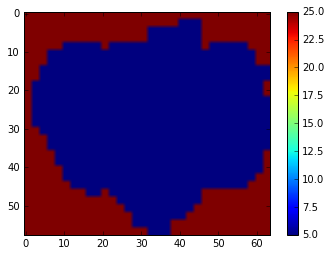

In [13]:
# -------------------------------------------------------------------------------------------------
# TURNING OFF ROUTING BY PCR IN COUPLED AREA
# -------------------------------------------------------------------------------------------------

newLDD = model_functions.noLDD(hydrologicModel, coupled_HLOG_indices, verbose_folder, verbose)

plt.figure()
plt.imshow(newLDD)
plt.colorbar()
#plt.savefig(os.path.join(verbose_folder,'coupledLDD.png'), dpi=300)

In [14]:
current_water_depth = hydrodynamicModel.get_var('s1') - hydrodynamicModel.get_var('bl')
current_water_depth_1D = current_water_depth[separator_1D:]
current_water_depth_2D = current_water_depth[:separator_1D]

In [15]:
inundatedArea_HDYN1D_2_HLOG, \
    inundatedArea_HDYN1D_2_HLOG_BMI = model_functions.determine_InundationArea1D_Hydrodynamics(couple_HLOG_2_HDYN,
                                                                                               coupled_HLOG_indices,
                                                                                               current_water_depth_1D,
                                                                                               threshold_inundated_depth,
                                                                                               cellAreaSpherical_1D,
                                                                                               cellarea_data_pcr,
                                                                                               landmask_pcr)

In [16]:
inundatedArea_HDYN2D_2_HLOG, \
    inundatedArea_HDYN2D_2_HLOG_BMI, \
        inundatedFraction_HDYN2D_2_HLOG, \
            inundatedFraction_HDYN2D_2_HLOG_BMI = model_functions.determine_InundationArea2D_Hydrodynamics(couple_HLOG_2_HDYN_2way,
                                                                                                           coupled_HLOG_indices_2way,
                                                                                                           current_water_depth_2D,
                                                                                                           threshold_inundated_depth,
                                                                                                           cellAreaSpherical_2D,
                                                                                                           cellarea_data_pcr,
                                                                                                           landmask_pcr)

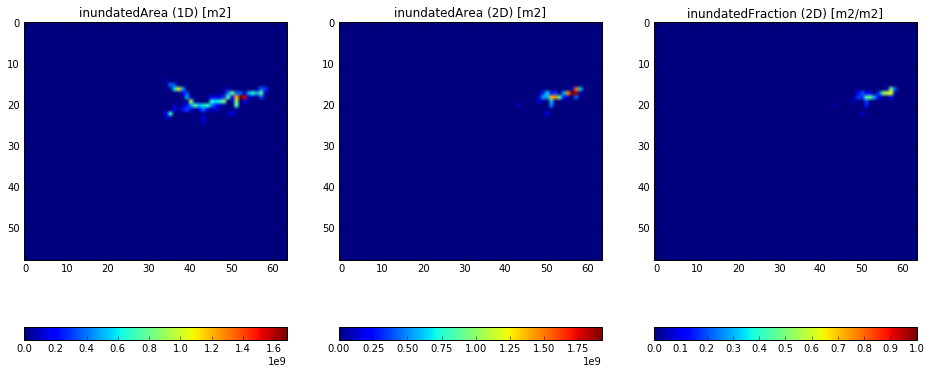

In [17]:
plt.figure(figsize=(16,8))
plt.subplot(131)
plt.title('inundatedArea (1D) [m2]')
plt.imshow(inundatedArea_HDYN1D_2_HLOG_BMI)
plt.colorbar(orientation='horizontal')
plt.subplot(132)
plt.title('inundatedArea (2D) [m2]')
plt.imshow(inundatedArea_HDYN2D_2_HLOG_BMI)
plt.colorbar(orientation='horizontal')
plt.subplot(133)
plt.title('inundatedFraction (2D) [m2/m2]')
plt.imshow(inundatedFraction_HDYN2D_2_HLOG_BMI, vmin=0, vmax=1)
plt.colorbar(orientation='horizontal')
#plt.savefig(os.path.join(verbose_folder,'inundatedAreaAndFraction_HDYN_2_HLOG_BMI.png'), dpi=300)

In [18]:
current_water_volume = np.copy(hydrodynamicModel.get_var('vol1')) # all hydrodyancmi cells
current_water_volume_1D = current_water_volume[separator_1D:] # 1D channel cells
current_water_volume_2D = current_water_volume[:separator_1D] # 2D floodplain cells

In [19]:
waterVolume_HDYN1D_2_HLOG,\
    waterVolume_HDYN1D_2_HLOG_BMI,\
        waterDepth_HDYN1D_2_HLOG_BMI = model_functions.determine_inundationVolume_HDYN_1D(hydrologicModel,
                                                                                          inundatedArea_HDYN1D_2_HLOG,
                                                                                          current_water_volume_1D,
                                                                                          couple_HLOG_2_HDYN,
                                                                                          coupled_HLOG_indices, 
                                                                                          landmask_pcr)

In [20]:
waterVolume_HDYN2D_2_HLOG_BMI,\
    waterDepth_HDYN2D_2_HLOG_BMI = model_functions.determine_inundationVolume_HDYN_2D(current_water_volume_2D, 
                                                                                      inundatedArea_HDYN2D_2_HLOG,
                                                                                      waterVolume_HDYN1D_2_HLOG_BMI,
                                                                                      couple_HLOG_2_HDYN_2way,
                                                                                      coupled_HLOG_indices_2way,
                                                                                      landmask_pcr)

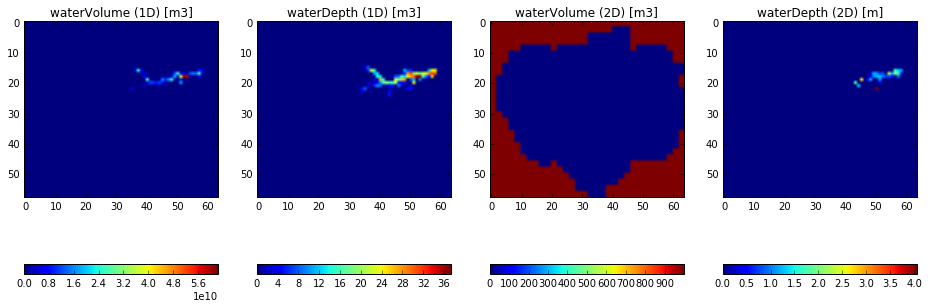

In [21]:
plt.figure(figsize=(16,8))
plt.subplot(141)
plt.title('waterVolume (1D) [m3]')
plt.imshow(waterVolume_HDYN1D_2_HLOG_BMI)
plt.colorbar(orientation='horizontal')
plt.subplot(142)
plt.title('waterDepth (1D) [m3]')
plt.imshow(waterDepth_HDYN1D_2_HLOG_BMI)
plt.colorbar(orientation='horizontal')
plt.subplot(143)
plt.title('waterVolume (2D) [m3]')
plt.imshow(waterVolume_HDYN2D_2_HLOG_BMI)
plt.colorbar(orientation='horizontal')
plt.subplot(144)
plt.title('waterDepth (2D) [m]')
plt.imshow(waterDepth_HDYN2D_2_HLOG_BMI)
plt.colorbar(orientation='horizontal')
#plt.savefig(os.path.join(verbose_folder,'inundatedVolumeAndDepth_HDYN_2_HLOG_BMI.png'), dpi=300)

In [22]:
ini_channelStorage = np.copy(hydrologicModel.get_var('channelStorage'))

if couple_channelStorage == False:
    waterVolume_HDYN1D_2_HLOG_BMI = np.zeros_like(waterVolume_HDYN2D_2_HLOG_BMI)

model_functions.updateStorage(hydrologicModel, landmask_pcr, missing_value_pcr, missing_value_landmask, coupled_HLOG_indices, couple_HLOG_2_HDYN, waterVolume_HDYN1D_2_HLOG_BMI)

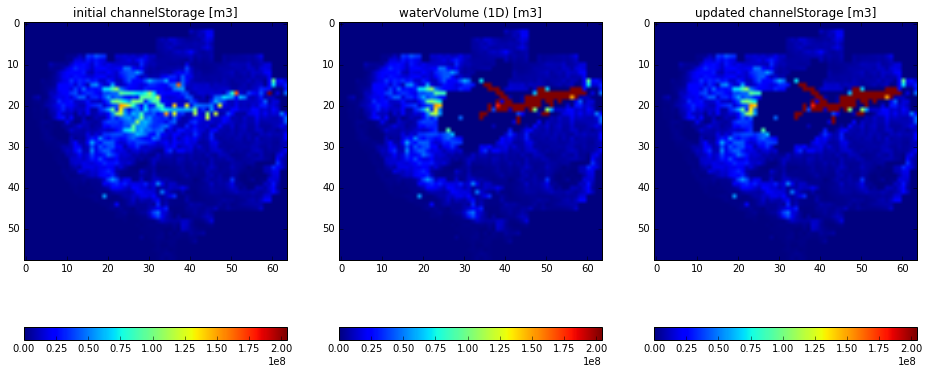

In [23]:
plt.figure(figsize=(16,8))
plt.subplot(131)
plt.title('initial channelStorage [m3]')
plt.imshow(ini_channelStorage, vmax=np.max(ini_channelStorage))
plt.colorbar(orientation='horizontal')
plt.subplot(132)
plt.title('waterVolume (1D) [m3]')
plt.imshow(waterVolume_HDYN1D_2_HLOG_BMI, vmax=np.max(ini_channelStorage))
plt.colorbar(orientation='horizontal')
plt.subplot(133)
plt.title('updated channelStorage [m3]')
plt.imshow(hydrologicModel.get_var('channelStorage'), vmax=np.max(ini_channelStorage))
plt.colorbar(orientation='horizontal')
#plt.savefig(os.path.join(verbose_folder,'iniAndUpdatedChannelStoragePCR.png'), dpi=300)

In [24]:
model_functions.updateHydrologicVariables(hydrologicModel,
                                          waterDepth_HDYN2D_2_HLOG_BMI,
                                          inundatedFraction_HDYN2D_2_HLOG_BMI)

max fWL 4.05598413266


In [25]:
hydrologicModel.update(1)

2018-02-21 12:37:43,750 model.pcrglobwb INFO Reading forcings for time 1984-01-01
2018-02-21 12:37:44,316 model.pcrglobwb INFO Updating model for time 1984-01-01
2018-02-21 12:37:44,508 model.landSurface INFO Updating land cover: forest
2018-02-21 12:37:44,511 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/forest/Global_CropCoefficientKc-Forest_30min.nc ; variable: kc !!!!!!
The date 1984-01-01 is NOT available. The date 2000-1-1 is used.

2018-02-21 12:37:44,690 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/forest/interceptCapInputForest366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-01-01 is NOT available. The date 2000-1-1 is used.

2018-02-21 12:37:44,897 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/forest/coverFractionInputForest366days.nc ; variable: cov

In [26]:
#waterVolume_HDYN2D_2_HLOG_BMI = np.zeros_like(waterVolume_HDYN2D_2_HLOG_BMI)

delta_volume_PCR, delta_volume_PCR_1way = model_functions.calculateDeltaVolumes(hydrologicModel,
                                                                                missing_value_pcr, 
                                                                                secPerDay, 
                                                                                coupled_HLOG_indices, 
                                                                                cellarea_data_pcr, 
                                                                                waterVolume_HDYN2D_2_HLOG_BMI)


delta volume of all PCR cells before feedback from DFM: 3.71E+10
feedback volume from FM: 1.30E+06 
delta volume of all PCR cells after feedback from DFM: 3.71E+10
reduction by  0.0 %
delta volume for PCR cells coupled to hydrodynamic channels 2.23E+10


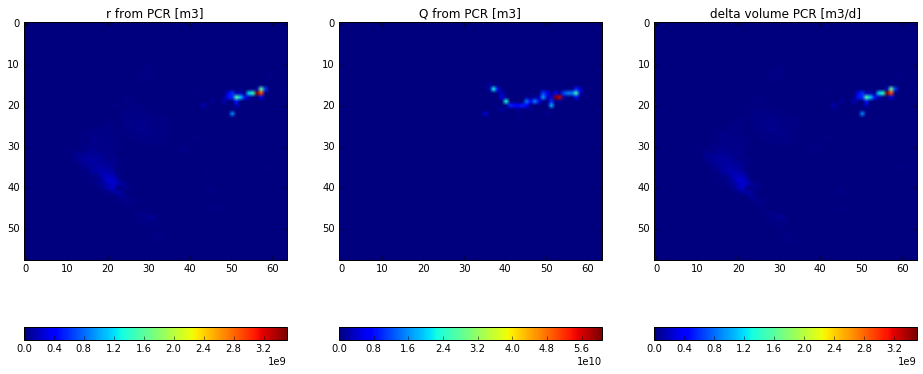

In [27]:
r = np.copy(hydrologicModel.get_var('landSurfaceRunoff'))
r = r * cellarea_data_pcr
r[r<=0.] = -999
Q = np.copy(hydrologicModel.get_var('discharge'))
Q = Q*86400.
Q[Q<=0.] = -999

plt.figure(figsize=(16,8))
plt.subplot(131)
plt.title('r from PCR [m3]')
plt.imshow(r)
plt.colorbar(orientation='horizontal')
plt.subplot(132)
plt.title('Q from PCR [m3]')
plt.imshow(Q)
plt.colorbar(orientation='horizontal')
plt.subplot(133)
plt.title('delta volume PCR [m3/d]')
plt.imshow(delta_volume_PCR)
plt.colorbar(orientation='horizontal')

In [28]:
delta_water_DFM_1way, verbose_volume_DFM_1way = model_functions.calculateDeltaWater(hydrodynamicModel, 
                                                                                    couple_HDYN_2_HLOG, 
                                                                                    couple_HLOG_2_HDYN,
                                                                                    coupled_HLOG_indices,
                                                                                    delta_volume_PCR_1way, 
                                                                                    cellAreaSpherical_1D, 
                                                                                    fraction_timestep, 
                                                                                    model_type, 
                                                                                    use_Fluxes)

In [29]:
model_functions.updateModel(hydrodynamicModel, 
                            delta_water_DFM_1way, 
                            update_step, 
                            separator_1D, 
                            use_Fluxes, 
                            use_RFS, 
                            model_type, 
                            verbose)

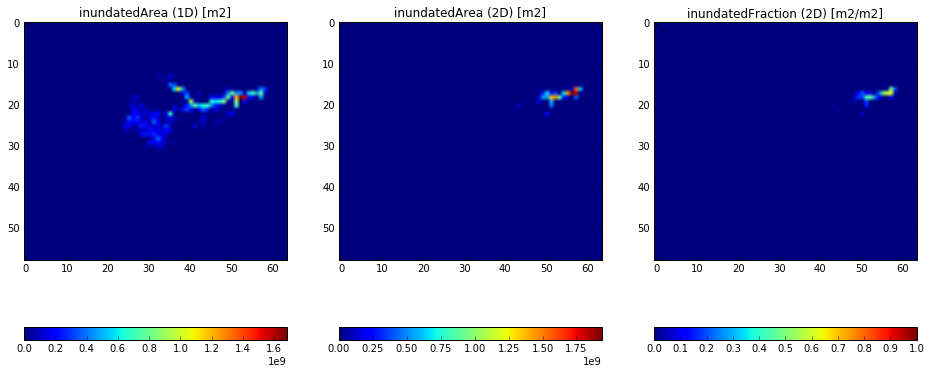

In [30]:
current_water_depth = hydrodynamicModel.get_var('s1') - hydrodynamicModel.get_var('bl')
current_water_depth_1D = current_water_depth[separator_1D:]
current_water_depth_2D = current_water_depth[:separator_1D]

inundatedArea_HDYN1D_2_HLOG, \
    inundatedArea_HDYN1D_2_HLOG_BMI = model_functions.determine_InundationArea1D_Hydrodynamics(couple_HLOG_2_HDYN,
                                                                                               coupled_HLOG_indices,
                                                                                               current_water_depth_1D,
                                                                                               threshold_inundated_depth,
                                                                                               cellAreaSpherical_1D,
                                                                                               cellarea_data_pcr,
                                                                                               landmask_pcr)

inundatedArea_HDYN2D_2_HLOG, \
    inundatedArea_HDYN2D_2_HLOG_BMI, \
        inundatedFraction_HDYN2D_2_HLOG, \
            inundatedFraction_HDYN2D_2_HLOG_BMI = model_functions.determine_InundationArea2D_Hydrodynamics(couple_HLOG_2_HDYN_2way,
                                                                                                           coupled_HLOG_indices_2way,
                                                                                                           current_water_depth_2D,
                                                                                                           threshold_inundated_depth,
                                                                                                           cellAreaSpherical_2D,
                                                                                                           cellarea_data_pcr,
                                                                                                           landmask_pcr)

plt.figure(figsize=(16,8))
plt.subplot(131)
plt.title('inundatedArea (1D) [m2]')
plt.imshow(inundatedArea_HDYN1D_2_HLOG_BMI)
plt.colorbar(orientation='horizontal')
plt.subplot(132)
plt.title('inundatedArea (2D) [m2]')
plt.imshow(inundatedArea_HDYN2D_2_HLOG_BMI)
plt.colorbar(orientation='horizontal')
plt.subplot(133)
plt.title('inundatedFraction (2D) [m2/m2]')
plt.imshow(inundatedFraction_HDYN2D_2_HLOG_BMI, vmin=0, vmax=1)
plt.colorbar(orientation='horizontal')

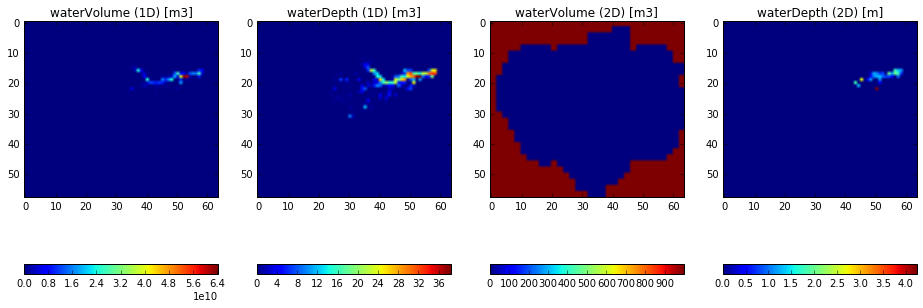

In [31]:
current_water_volume = np.copy(hydrodynamicModel.get_var('vol1'))
current_water_volume_1D = current_water_volume[separator_1D:]
current_water_volume_2D = current_water_volume[:separator_1D]

waterVolume_HDYN1D_2_HLOG,\
    waterVolume_HDYN1D_2_HLOG_BMI,\
        waterDepth_HDYN1D_2_HLOG_BMI = model_functions.determine_inundationVolume_HDYN_1D(hydrologicModel,
                                                                                          inundatedArea_HDYN1D_2_HLOG,
                                                                                          current_water_volume_1D,
                                                                                          couple_HLOG_2_HDYN,
                                                                                          coupled_HLOG_indices, 
                                                                                          landmask_pcr)

waterVolume_HDYN2D_2_HLOG_BMI,\
    waterDepth_HDYN2D_2_HLOG_BMI = model_functions.determine_inundationVolume_HDYN_2D(current_water_volume_2D, 
                                                                                      inundatedArea_HDYN2D_2_HLOG,
                                                                                      waterVolume_HDYN1D_2_HLOG_BMI,
                                                                                      couple_HLOG_2_HDYN_2way,
                                                                                      coupled_HLOG_indices_2way,
                                                                                      landmask_pcr)

plt.figure(figsize=(16,8))
plt.subplot(141)
plt.title('waterVolume (1D) [m3]')
plt.imshow(waterVolume_HDYN1D_2_HLOG_BMI)
plt.colorbar(orientation='horizontal')
plt.subplot(142)
plt.title('waterDepth (1D) [m3]')
plt.imshow(waterDepth_HDYN1D_2_HLOG_BMI)
plt.colorbar(orientation='horizontal')
plt.subplot(143)
plt.title('waterVolume (2D) [m3]')
plt.imshow(waterVolume_HDYN2D_2_HLOG_BMI)
plt.colorbar(orientation='horizontal')
plt.subplot(144)
plt.title('waterDepth (2D) [m]')
plt.imshow(waterDepth_HDYN2D_2_HLOG_BMI)
plt.colorbar(orientation='horizontal')
# plt.savefig(os.path.join(verbose_folder,'inundatedVolumeAndDepth_HDYN_2_HLOG_BMI.png'), dpi=300)

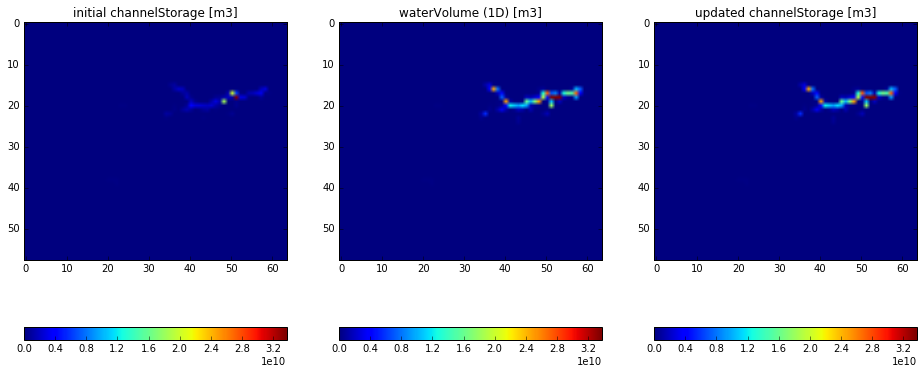

In [32]:
ini_channelStorage = np.copy(hydrologicModel.get_var('channelStorage'))

if couple_channelStorage == False:
    waterVolume_HDYN1D_2_HLOG_BMI = np.zeros_like(waterVolume_HDYN2D_2_HLOG_BMI)

model_functions.updateStorage(hydrologicModel, landmask_pcr, missing_value_pcr, missing_value_landmask, coupled_HLOG_indices, couple_HLOG_2_HDYN, waterVolume_HDYN1D_2_HLOG_BMI)

plt.figure(figsize=(16,8))
plt.subplot(131)
plt.title('initial channelStorage [m3]')
plt.imshow(ini_channelStorage, vmax=np.max(ini_channelStorage))
plt.colorbar(orientation='horizontal')
plt.subplot(132)
plt.title('waterVolume (1D) [m3]')
plt.imshow(waterVolume_HDYN1D_2_HLOG_BMI, vmax=np.max(ini_channelStorage))
plt.colorbar(orientation='horizontal')
plt.subplot(133)
plt.title('updated channelStorage [m3]')
plt.imshow(hydrologicModel.get_var('channelStorage'), vmax=np.max(ini_channelStorage))
plt.colorbar(orientation='horizontal')
#plt.savefig(os.path.join(verbose_folder,'iniAndUpdatedChannelStoragePCR.png'), dpi=300)

In [33]:
model_functions.updateHydrologicVariables(hydrologicModel,
                                          waterDepth_HDYN2D_2_HLOG_BMI,
                                          inundatedFraction_HDYN2D_2_HLOG_BMI)

max fWL 4.23892306981


In [34]:
model_functions.noLDD(hydrologicModel, coupled_HLOG_indices, verbose_folder, verbose)

hydrologicModel.update(1)

2018-02-21 12:38:06,033 model.pcrglobwb INFO Reading forcings for time 1984-01-02
2018-02-21 12:38:06,854 model.pcrglobwb INFO Updating model for time 1984-01-02
2018-02-21 12:38:06,866 model.landSurface INFO Updating land cover: forest
2018-02-21 12:38:06,871 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/forest/Global_CropCoefficientKc-Forest_30min.nc ; variable: kc !!!!!!
The date 1984-01-02 is NOT available. The date 2000-1-2 is used.

2018-02-21 12:38:07,124 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/forest/interceptCapInputForest366days.nc ; variable: interceptCapInput !!!!!!
The date 1984-01-02 is NOT available. The date 2000-1-2 is used.

2018-02-21 12:38:07,401 model.virtualOS WARNING 
WARNING related to the netcdf file: /home/jannis/PhD/data_PCR/input/AMA/input30min/landCover/forest/coverFractionInputForest366days.nc ; variable: cov

In [35]:
delta_volume_PCR, delta_volume_PCR_1way = model_functions.calculateDeltaVolumes(hydrologicModel,
                                                                                missing_value_pcr, 
                                                                                secPerDay, 
                                                                                coupled_HLOG_indices, 
                                                                                cellarea_data_pcr, 
                                                                                waterVolume_HDYN2D_2_HLOG_BMI)


delta volume of all PCR cells before feedback from DFM: 2.59E+10
feedback volume from FM: 1.30E+06 
delta volume of all PCR cells after feedback from DFM: 2.59E+10
reduction by  0.01 %
delta volume for PCR cells coupled to hydrodynamic channels 2.14E+10


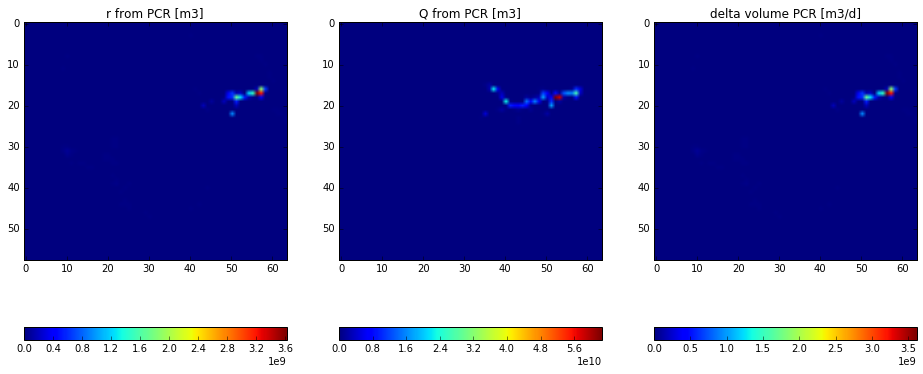

In [36]:
r = np.copy(hydrologicModel.get_var('landSurfaceRunoff'))
r = r * cellarea_data_pcr
r[r<=0.] = 0.
Q = np.copy(hydrologicModel.get_var('discharge'))
Q = Q*86400.
Q[Q<=0.] = 0.

plt.figure(figsize=(16,8))
plt.subplot(131)
plt.title('r from PCR [m3]')
plt.imshow(r)
plt.colorbar(orientation='horizontal')
plt.subplot(132)
plt.title('Q from PCR [m3]')
plt.imshow(Q)
plt.colorbar(orientation='horizontal')
plt.subplot(133)
plt.title('delta volume PCR [m3/d]')
plt.imshow(delta_volume_PCR)
plt.colorbar(orientation='horizontal')

In [37]:
delta_water_DFM_1way, verbose_volume_DFM_1way = model_functions.calculateDeltaWater(hydrodynamicModel, 
                                                                                    couple_HDYN_2_HLOG, 
                                                                                    couple_HLOG_2_HDYN,
                                                                                    coupled_HLOG_indices,
                                                                                    delta_volume_PCR_1way, 
                                                                                    cellAreaSpherical_1D, 
                                                                                    fraction_timestep, 
                                                                                    model_type, 
                                                                                    use_Fluxes)

model_functions.updateModel(hydrodynamicModel, 
                            delta_water_DFM_1way, 
                            update_step, 
                            separator_1D, 
                            use_Fluxes, 
                            use_RFS, 
                            model_type, 
                            verbose)

In [38]:
np.max(waterDepth_HDYN1D_2_HLOG_BMI)

38.44276

In [39]:
execute_all = False

In [40]:
if execute_all == True:

    while hydrologicModel.get_time_step() < end_time_pcr:

        current_water_depth = hydrodynamicModel.get_var('s1') - hydrodynamicModel.get_var('bl')
        current_water_depth_1D = current_water_depth[separator_1D:]
        current_water_depth_2D = current_water_depth[:separator_1D]

        inundatedArea_HDYN1D_2_HLOG, \
            inundatedArea_HDYN1D_2_HLOG_BMI = model_functions.determine_InundationArea1D_Hydrodynamics(couple_HLOG_2_HDYN,
                                                                                                       coupled_HLOG_indices,
                                                                                                       current_water_depth_1D,
                                                                                                       threshold_inundated_depth,
                                                                                                       cellAreaSpherical_1D,
                                                                                                       landmask_pcr)

        inundatedArea_HDYN2D_2_HLOG, \
            inundatedArea_HDYN2D_2_HLOG_BMI, \
                inundatedFraction_HDYN2D_2_HLOG, \
                    inundatedFraction_HDYN2D_2_HLOG_BMI = model_functions.determine_InundationArea2D_Hydrodynamics(couple_HLOG_2_HDYN_2way,
                                                                                                                   coupled_HLOG_indices_2way,
                                                                                                                   current_water_depth_2D,
                                                                                                                   threshold_inundated_depth,
                                                                                                                   cellAreaSpherical_2D,
                                                                                                                   cellarea_data_pcr,
                                                                                                                   landmask_pcr)

        current_water_volume = np.copy(hydrodynamicModel.get_var('vol1'))
        current_water_volume_1D = current_water_volume[separator_1D:]
        current_water_volume_2D = current_water_volume[:separator_1D]

        waterVolume_HDYN1D_2_HLOG,\
            waterVolume_HDYN1D_2_HLOG_BMI,\
                waterDepth_HDYN1D_2_HLOG_BMI = model_functions.determine_inundationVolume_HDYN_1D(hydrologicModel,
                                                                                                  inundatedArea_HDYN1D_2_HLOG,
                                                                                                  current_water_volume_1D,
                                                                                                  couple_HLOG_2_HDYN,
                                                                                                  coupled_HLOG_indices, 
                                                                                                  landmask_pcr)

        waterVolume_HDYN2D_2_HLOG_BMI,\
            waterDepth_HDYN2D_2_HLOG_BMI = model_functions.determine_inundationVolume_HDYN_2D(current_water_volume_2D, 
                                                                                              inundatedArea_HDYN2D_2_HLOG,
                                                                                              waterVolume_HDYN1D_2_HLOG_BMI,
                                                                                              couple_HLOG_2_HDYN_2way,
                                                                                              coupled_HLOG_indices_2way,
                                                                                              landmask_pcr)

        ini_channelStorage = np.copy(hydrologicModel.get_var('channelStorage'))

        if couple_channelStorage == False:
            waterVolume_HDYN1D_2_HLOG_BMI = np.zeros_like(waterVolume_HDYN2D_2_HLOG_BMI)

        model_functions.updateStorage(hydrologicModel, landmask_pcr, missing_value_pcr, missing_value_landmask, coupled_HLOG_indices, couple_HLOG_2_HDYN, waterVolume_HDYN1D_2_HLOG_BMI)

        model_functions.updateHydrologicVariables(hydrologicModel,
                                                  waterDepth_HDYN2D_2_HLOG_BMI,
                                                  inundatedFraction_HDYN2D_2_HLOG_BMI)

        model_functions.noLDD(hydrologicModel, coupled_HLOG_indices, verbose_folder, verbose)

        hydrologicModel.update(1)

        delta_volume_PCR, delta_volume_PCR_1way = model_functions.calculateDeltaVolumes(hydrologicModel,
                                                                                        missing_value_pcr, 
                                                                                        secPerDay, 
                                                                                        coupled_HLOG_indices, 
                                                                                        cellarea_data_pcr, 
                                                                                        waterVolume_HDYN2D_2_HLOG_BMI)

        delta_water_DFM_1way, verbose_volume_DFM_1way = model_functions.calculateDeltaWater(hydrodynamicModel, 
                                                                                            couple_HDYN_2_HLOG, 
                                                                                            couple_HLOG_2_HDYN,
                                                                                            coupled_HLOG_indices,
                                                                                            delta_volume_PCR_1way, 
                                                                                            cellAreaSpherical_1D, 
                                                                                            fraction_timestep, 
                                                                                            model_type, 
                                                                                            use_Fluxes)

        model_functions.updateModel(hydrodynamicModel, 
                                    delta_water_DFM_1way, 
                                    update_step, 
                                    separator_1D, 
                                    use_Fluxes, 
                                    use_RFS, 
                                    model_type, 
                                    verbose)


    hydrodynamicModel.finalize()
    hydrologicModel.finalize()